# Introducción

En este notebook se presentan las simulaciones de supernovas superluminosas (SLSN) realizadas para los campos *Wide Fast Deep (WFD)* del LSST.  
El objetivo general es generar y analizar curvas de luz sintéticas para distintos modelos de SLSN, con el fin de evaluar la cobertura temporal, calidad fotométrica y posibles estrategias de detección.

Estas simulaciones permiten entender el desempeño esperado del LSST en la observación de eventos transitorios extremadamente luminosos, y contribuyen a optimizar los criterios de clasificación y selección en futuros catálogos de supernovas.

El notebook está organizado en etapas: configuración inicial, definición de modelos, generación de curvas de luz, lectura de resultados, visualización y análisis.

# Configuración inicial
En esta sección se importan las librerías necesarias y se configuran las rutas de acceso a los datos.

In [ ]:
!pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 25.1 MB/s eta 0:00:00


In [ ]:
# =============================================================================
# CONFIGURACIÓN E IMPORTACIONES ESPECÍFICAS PARA ARCHIVOS
# =============================================================================

import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.neighbors import BallTree
import healpy as hp

print("=== INICIALIZACIÓN ANÁLISIS ARCHIVOS AGN ===")


=== INICIALIZACIÓN ANÁLISIS ARCHIVOS AGN ===


#Carga de archivos

In [ ]:
from google.colab import files

print("=== SUBIENDO ARCHIVOS SLSN-I ===")
uploaded = files.upload()

# Verificar archivos subidos
print("\n=== ARCHIVOS SUBIDOS ===")
for fn in uploaded.keys():
    print(f'Archivo: "{fn}" - Tamaño: {len(uploaded[fn])} bytes')

# Lista de archivos esperados
expected_files = [
    'SLSN-I_WFD_20251020_PHOT.FITS',
    'SLSN-I_WFD_20251020_HEAD.FITS',
    'SLSN-I_WFD_20251020.DUMP'
]

print("\n=== VERIFICACIÓN DE ARCHIVOS ===")
for file in expected_files:
    if file in uploaded.keys():
        print(f"✅ {file} - CARGADO")
    else:
        print(f"❌ {file} - FALTANTE")

=== SUBIENDO ARCHIVOS SLSN-I ===


Saving SLSN-I_WFD_20251020.DUMP to SLSN-I_WFD_20251020.DUMP
Saving SLSN-I_WFD_20251020.LIST to SLSN-I_WFD_20251020.LIST
Saving SLSN-I_WFD_20251020.README to SLSN-I_WFD_20251020.README
Saving SLSN-I_WFD_20251020_HEAD.FITS to SLSN-I_WFD_20251020_HEAD.FITS
Saving SLSN-I_WFD_20251020_PHOT.FITS to SLSN-I_WFD_20251020_PHOT.FITS

=== ARCHIVOS SUBIDOS ===
Archivo: "SLSN-I_WFD_20251020.DUMP" - Tamaño: 746582 bytes
Archivo: "SLSN-I_WFD_20251020.LIST" - Tamaño: 29 bytes
Archivo: "SLSN-I_WFD_20251020.README" - Tamaño: 7289 bytes
Archivo: "SLSN-I_WFD_20251020_HEAD.FITS" - Tamaño: 452160 bytes
Archivo: "SLSN-I_WFD_20251020_PHOT.FITS" - Tamaño: 7957440 bytes

=== VERIFICACIÓN DE ARCHIVOS ===
✅ SLSN-I_WFD_20251020_PHOT.FITS - CARGADO
✅ SLSN-I_WFD_20251020_HEAD.FITS - CARGADO
✅ SLSN-I_WFD_20251020.DUMP - CARGADO


In [ ]:
# =============================================================================
# CARGA DE ARCHIVOS DESDE RUTA LOCAL (PARA ENTORNO ANACONDA/LOCAL)
# =============================================================================

import pandas as pd
from astropy.table import Table
from astropy.io import fits
import os # Importar la librería os para manejar rutas de archivo

print("=== CARGANDO ARCHIVOS SLSN-I DESDE RUTA LOCAL ===")

# Define la ruta a la carpeta donde están tus archivos
# !!! CAMBIA ESTA RUTA A LA RUTA REAL EN TU COMPUTADORA !!!
local_data_path = r'C:\Users\HOME\Documents\SNANA\datasim_LSST_1\SLSN-I_WFD_20251020'

# Nombres de los archivos
phot_file = os.path.join(local_data_path, 'SLSN-I_WFD_20251020_PHOT.FITS')
head_file = os.path.join(local_data_path, 'SLSN-I_WFD_20251020_HEAD.FITS')
dump_file = os.path.join(local_data_path, 'SLSN-I_WFD_20251020.DUMP')

# Verificar si los archivos existen antes de intentar cargarlos
if not os.path.exists(phot_file):
    print(f"❌ Error: No se encontró el archivo PHOT en {phot_file}")
elif not os.path.exists(head_file):
     print(f"❌ Error: No se encontró el archivo HEAD en {head_file}")
else:
    # Cargar datos fotométricos
    try:
        phot_df = Table.read(phot_file, hdu=1).to_pandas()
        print(f"✅ PHOT cargado: {len(phot_df):,} filas × {len(phot_df.columns)} columnas")
    except Exception as e:
        print(f"❌ Error al cargar PHOT: {e}")
        phot_df = pd.DataFrame() # Crear DataFrame vacío en caso de error

    # Cargar metadatos
    try:
        head_df = Table.read(head_file, hdu=1).to_pandas()
        print(f"✅ HEAD cargado: {len(head_df):,} filas × {len(head_df.columns)} columnas")
    except Exception as e:
        print(f"❌ Error al cargar HEAD: {e}")
        head_df = pd.DataFrame() # Crear DataFrame vacío en caso de error

    # Cargar DUMP (si existe)
    # Usamos un bloque try-except porque el archivo DUMP podría no existir o tener un formato diferente
    try:
        if os.path.exists(dump_file):
            # Intentar leer como archivo ascii, ajusta el formato si es necesario
            dump_df = Table.read(dump_file, format='ascii').to_pandas()
            print(f"✅ DUMP cargado: {len(dump_df):,} filas × {len(dump_df.columns)} columnas")
        else:
            print(f"⚠️  Archivo DUMP no encontrado en {dump_file}. Se creará un DataFrame vacío.")
            dump_df = pd.DataFrame()
    except Exception as e:
        print(f"⚠️  Error al cargar DUMP: {e}. Se creará un DataFrame vacío.")
        dump_df = pd.DataFrame()


    print("\n=== CARGA DE ARCHIVOS COMPLETADA ===")

    # Opcional: Mostrar las primeras filas para verificar la carga
    # print("\n📋 Muestra de head_df:")
    # display(head_df.head())
    # print("\n📋 Muestra de phot_df:")
    # display(phot_df.head())
    # if not dump_df.empty:
    #     print("\n📋 Muestra de dump_df:")
    #     display(dump_df.head())

=== CARGANDO ARCHIVOS SLSN-I DESDE RUTA LOCAL ===
❌ Error: No se encontró el archivo PHOT en C:\Users\HOME\Documents\SNANA\datasim_LSST_1\SLSN-I_WFD_20251020/SLSN-I_WFD_20251020_PHOT.FITS


# Inspeccion y ajustes primarios

## Inspeccion de estructura de archivos fits

In [ ]:
print("🔍 INSPECCIONANDO ESTRUCTURA DE ARCHIVOS FITS...")

# Inspeccionar PHOT.FITS
print("\n📁 ARCHIVO PHOT.FITS:")
with fits.open('SLSN-I_WFD_20251020_PHOT.FITS') as hdul:
    hdul.info()
    phot_data = hdul[1].data
    print(f"   • Observaciones: {len(phot_data):,}")
    print(f"   • Columnas: {len(phot_data.names)}")
    print("   • Primeras 5 columnas:")
    for i, col in enumerate(phot_data.names[:5]):
        print(f"     {i}. {col}: {phot_data[col].dtype}")

# Inspeccionar HEAD.FITS
print("\n📁 ARCHIVO HEAD.FITS:")
with fits.open('SLSN-I_WFD_20251020_HEAD.FITS') as hdul:
    hdul.info()
    head_data = hdul[1].data
    print(f"   • Objetos: {len(head_data):,}")
    print(f"   • Columnas: {len(head_data.names)}")
    print("   • Columnas clave:")
    key_cols = ['SNID', 'RA', 'DEC', 'REDSHIFT_FINAL', 'SNTYPE', 'PTROBS_MIN', 'PTROBS_MAX']
    for col in key_cols:
        if col in head_data.names:
            print(f"     • {col}: {head_data[col].dtype}")

🔍 INSPECCIONANDO ESTRUCTURA DE ARCHIVOS FITS...

📁 ARCHIVO PHOT.FITS:
Filename: SLSN-I_WFD_20251020_PHOT.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      50   (0,)      
  1  Photometry    1 BinTableHDU     69   90264R x 20C   [1D, 2A, 1I, 12A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
   • Observaciones: 90,264
   • Columnas: 20
   • Primeras 5 columnas:
     0. MJD: >f8
     1. BAND: <U2
     2. CCDNUM: >i2
     3. FIELD: <U12
     4. PHOTFLAG: >i4

📁 ARCHIVO HEAD.FITS:
Filename: SLSN-I_WFD_20251020_HEAD.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (0,)      
  1  Header        1 BinTableHDU    471   585R x 154C   [16A, 1I, 1D, 1D, 1E, 1I, 1I, 1J, 1J, 1J, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1I, 1I, 1K, 1I, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1K, 1E, 1K, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E

## Dataframes a pandas

In [ ]:
print("🔄 CARGANDO DATOS A DATAFRAMES...")

# Cargar datos fotométricos
phot_df = Table.read('SLSN-I_WFD_20251020_PHOT.FITS', hdu=1).to_pandas()
print(f"✅ PHOT cargado: {len(phot_df):,} filas × {len(phot_df.columns)} columnas")

# Cargar metadatos
head_df = Table.read('SLSN-I_WFD_20251020_HEAD.FITS', hdu=1).to_pandas()
print(f"✅ HEAD cargado: {len(head_df):,} filas × {len(head_df.columns)} columnas")

# Cargar DUMP (si existe)
try:
    dump_df = Table.read('SLSN-I_WFD_20251020.DUMP', format='ascii').to_pandas()
    print(f"✅ DUMP cargado: {len(dump_df):,} filas × {len(dump_df.columns)} columnas")
except Exception as e:
    print(f"⚠️  DUMP no cargado: {e}")
    dump_df = pd.DataFrame()

print(f"\n📊 RESUMEN CARGA:")
print(f"   • Observaciones/objeto: {len(phot_df)/len(head_df):.1f}")
print(f"   • Memoria PHOT: {phot_df.memory_usage(deep=True).sum()/1e6:.1f} MB")
print(f"   • Memoria HEAD: {head_df.memory_usage(deep=True).sum()/1e6:.1f} MB")

🔄 CARGANDO DATOS A DATAFRAMES...
✅ PHOT cargado: 90,264 filas × 20 columnas
✅ HEAD cargado: 585 filas × 154 columnas
✅ DUMP cargado: 2,000 filas × 45 columnas

📊 RESUMEN CARGA:
   • Observaciones/objeto: 154.3
   • Memoria PHOT: 15.3 MB
   • Memoria HEAD: 0.5 MB


## Muestra de datos crudos

In [ ]:
print("📋 MUESTRA DE DATOS CRUDOS (primeras 5 filas):")

print("\n📷 DATOS FOTOMÉTRICOS (PHOT):")
print(phot_df.head())

print("\n📄 METADATOS (HEAD):")
print(head_df[['SNID', 'RA', 'DEC', 'REDSHIFT_FINAL', 'SNTYPE']].head())

print(f"\n🎯 ESTADÍSTICAS INICIALES:")
print(f"   • Bandas en PHOT: {phot_df['BAND'].str.decode('utf-8').str.strip().unique()}")
print(f"   • Rango MJD: {phot_df['MJD'].min():.1f} - {phot_df['MJD'].max():.1f}")
print(f"   • Rango FLUXCAL: {phot_df['FLUXCAL'].min():.2e} - {phot_df['FLUXCAL'].max():.2e}")

📋 MUESTRA DE DATOS CRUDOS (primeras 5 filas):

📷 DATOS FOTOMÉTRICOS (PHOT):
          MJD   BAND  CCDNUM            FIELD  PHOTFLAG  PHOTPROB    FLUXCAL  \
0  61273.3217  b'i '      -9  b'VOID        '         0      -9.0  -0.958262   
1  61274.3217  b'i '      -9  b'VOID        '         0      -9.0   1.935202   
2  61275.2749  b'z '      -9  b'VOID        '         0      -9.0  -6.107915   
3  61275.2985  b'Y '      -9  b'VOID        '         0      -9.0  21.686777   
4  61277.2866  b'i '      -9  b'VOID        '         0      -9.0   3.544434   

   FLUXCALERR  PSF_SIG1  PSF_SIG2  PSF_RATIO    SKY_SIG  SKY_SIG_T  RDNOISE  \
0    3.905797      1.44       0.0        0.0  36.959999        0.0     0.25   
1    4.939438      1.84       0.0        0.0  36.549999        0.0     0.25   
2    9.258770      1.71       0.0        0.0  53.450001        0.0     0.25   
3   23.135910      1.86       0.0        0.0  45.340000        0.0     0.25   
4    4.895317      1.29       0.0        0.0  52

## Transformaciones fisicas de flujo a magnitudes

In [ ]:
print("🎯 APLICANDO TRANSFORMACIONES FÍSICAS...")

# Limpieza de bandas
phot_df['BAND'] = phot_df['BAND'].str.decode('utf-8').str.strip()
print(f"✅ Bandas limpiadas: {sorted(phot_df['BAND'].unique())}")

# Transformaciones físicas
def flux_to_mag_AB(flux):
    """Conversión flujo → magnitud AB con zeropoint 27.5"""
    if flux <= 0:
        return np.nan
    return 27.5 - 2.5 * np.log10(flux)

def flux_to_mag_err_AB(flux, flux_err):
    """Error en magnitud AB"""
    if flux <= 0:
        return np.nan
    return (2.5 / np.log(10)) * (flux_err / flux)

# Aplicar transformaciones
phot_df['FLUX_uJy'] = phot_df['FLUXCAL'] * 10**(-1.44)
phot_df['FLUX_uJy_ERR'] = phot_df['FLUXCALERR'] * 10**(-1.44)
phot_df['MAG_AB'] = phot_df.apply(lambda x: flux_to_mag_AB(x['FLUXCAL']), axis=1)
phot_df['MAG_AB_ERR'] = phot_df.apply(lambda x: flux_to_mag_err_AB(x['FLUXCAL'], x['FLUXCALERR']), axis=1)

# Preparar coordenadas para análisis espacial
head_df['rad_ra'] = np.radians(head_df['RA'])
head_df['rad_dec'] = np.radians(head_df['DEC'])

print("✅ TRANSFORMACIONES COMPLETADAS:")
print(f"   • Observaciones con flujo positivo: {(phot_df['FLUXCAL'] > 0).sum():,}")
print(f"   • Rango magnitudes AB: {phot_df['MAG_AB'].min():.2f} - {phot_df['MAG_AB'].max():.2f}")
print(f"   • Rango flujo μJy: {phot_df['FLUX_uJy'].min():.2f} - {phot_df['FLUX_uJy'].max():.2f}")

🎯 APLICANDO TRANSFORMACIONES FÍSICAS...
✅ Bandas limpiadas: ['-', 'Y', 'g', 'i', 'r', 'u', 'z']
✅ TRANSFORMACIONES COMPLETADAS:
   • Observaciones con flujo positivo: 62,663
   • Rango magnitudes AB: 18.23 - 40.82
   • Rango flujo μJy: -28.21 - 184.87


In [ ]:
display(phot_df.head())

MJD BAND  CCDNUM            FIELD  PHOTFLAG  PHOTPROB    FLUXCAL  \
0  61273.3217    i      -9  b'VOID        '         0      -9.0  -0.958262   
1  61274.3217    i      -9  b'VOID        '         0      -9.0   1.935202   
2  61275.2749    z      -9  b'VOID        '         0      -9.0  -6.107915   
3  61275.2985    Y      -9  b'VOID        '         0      -9.0  21.686777   
4  61277.2866    i      -9  b'VOID        '         0      -9.0   3.544434   

   FLUXCALERR  PSF_SIG1  PSF_SIG2  ...     ZEROPT  ZEROPT_ERR  GAIN  XPIX  \
0    3.905797      1.44       0.0  ...  31.709999       0.005   1.0  -9.0   
1    4.939438      1.84       0.0  ...  31.709999       0.005   1.0  -9.0   
2    9.258770      1.71       0.0  ...  31.360001       0.005   1.0  -9.0   
3   23.135910      1.86       0.0  ...  30.280001       0.005   1.0  -9.0   
4    4.895317      1.29       0.0  ...  31.719999       0.005   1.0  -9.0   

   YPIX  SIM_MAGOBS  FLUX_uJy  FLUX_uJy_ERR     MAG_AB  MAG_AB_ERR  
0  -9.0        99.0 -0.034792      0.141811        NaN         NaN  
1  -9.0        99.0  0.070263      0.179340  26.783184    2.771249  
2  -9.0        99.0 -0.221765      0.336166        NaN         NaN  
3  -9.0        99.0  0.787399      0.840014  24.159512    1.158286  
4  -9.0        99.0  0.128691      0.177738  26.126133    1.499540  

[5 rows x 24 columns]

In [ ]:
display(head_df.head())


SNID  FAKE          RA        DEC  PIXSIZE  NXPIX  NYPIX  \
0  b'3               '     2   31.113281 -16.957763      0.2     -9     -9   
1  b'5               '     2  171.386719  13.248015      0.2     -9     -9   
2  b'8               '     2  288.984375 -23.480535      0.2     -9     -9   
3  b'11              '     2   37.968750   0.149208      0.2     -9     -9   
4  b'13              '     2   30.410156 -17.270005      0.2     -9     -9   

   SNTYPE  NOBS  PTROBS_MIN  ...  SIM_PEAKMAG_Y  SIM_EXPOSURE_u  \
0       0   109           1  ...      23.244108             1.0   
1       0    98         111  ...      20.554173             1.0   
2       0   253         210  ...      20.740332             1.0   
3       0   196         464  ...      20.024904             1.0   
4       0    68         661  ...      22.498859             1.0   

   SIM_EXPOSURE_g  SIM_EXPOSURE_r  SIM_EXPOSURE_i  SIM_EXPOSURE_z  \
0             1.0             1.0             1.0             1.0   
1             1.0             1.0             1.0             1.0   
2             1.0             1.0             1.0             1.0   
3             1.0             1.0             1.0             1.0   
4             1.0             1.0             1.0             1.0   

   SIM_EXPOSURE_Y  SIM_SUBSAMPLE_INDEX    rad_ra   rad_dec  
0             1.0                   -9  0.543029 -0.295969  
1             1.0                   -9  2.991263  0.231221  
2             1.0                   -9  5.043729 -0.409813  
3             1.0                   -9  0.662680  0.002604  
4             1.0                   -9  0.530757 -0.301418  

[5 rows x 156 columns]

In [ ]:
# Configurar opciones de visualización para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Mostrar todas las columnas de head_df
display(head_df)

# Restaurar opciones de visualización predeterminadas (opcional, buena práctica)
pd.reset_option('display.max_columns')

SNID  FAKE          RA        DEC  PIXSIZE  NXPIX  NYPIX  \
0    b'3               '     2   31.113281 -16.957763      0.2     -9     -9   
1    b'5               '     2  171.386719  13.248015      0.2     -9     -9   
2    b'8               '     2  288.984375 -23.480535      0.2     -9     -9   
3    b'11              '     2   37.968750   0.149208      0.2     -9     -9   
4    b'13              '     2   30.410156 -17.270005      0.2     -9     -9   
..                   ...   ...         ...        ...      ...    ...    ...   
580  b'1981            '     2  283.007812 -38.111040      0.2     -9     -9   
581  b'1982            '     2  128.671875   7.933337      0.2     -9     -9   
582  b'1987            '     2   19.630872 -62.508568      0.2     -9     -9   
583  b'1994            '     2  148.886719  -9.896853      0.2     -9     -9   
584  b'1996            '     2  218.349754 -52.222925      0.2     -9     -9   

     SNTYPE  NOBS  PTROBS_MIN  PTROBS_MAX     MWEBV  MWEBV_ERR  \
0         0   109           1         109  0.031942   0.005111   
1         0    98         111         208  0.029188   0.004670   
2         0   253         210         462  0.130140   0.020822   
3         0   196         464         659  0.026494   0.004239   
4         0    68         661         728  0.025276   0.004044   
..      ...   ...         ...         ...       ...        ...   
580       0   201       89437       89637  0.106249   0.017000   
581       0   187       89639       89825  0.028998   0.004640   
582       0   126       89827       89952  0.020601   0.003296   
583       0   227       89954       90180  0.057914   0.009266   
584       0    82       90182       90263  0.437843   0.070055   

     REDSHIFT_HELIO  REDSHIFT_HELIO_ERR  REDSHIFT_FINAL  REDSHIFT_FINAL_ERR  \
0          3.374862                 0.0        3.371318                 0.0   
1          0.968685                 0.0        0.970963                 0.0   
2          0.648738                 0.0        0.647881                 0.0   
3          0.929717                 0.0        0.928199                 0.0   
4          1.950797                 0.0        1.948384                 0.0   
..              ...                 ...             ...                 ...   
580        1.525385                 0.0        1.524587                 0.0   
581        1.045752                 0.0        1.047633                 0.0   
582        2.930914                 0.0        2.929544                 0.0   
583        1.191272                 0.0        1.193830                 0.0   
584        0.485094                 0.0        0.485980                 0.0   

     MASK_REDSHIFT_SOURCE  VPEC  VPEC_ERR  LENSDMU  LENSDMU_ERR  \
0                       2   0.0       0.0      0.0          0.0   
1                       2   0.0       0.0      0.0          0.0   
2                       2   0.0       0.0      0.0          0.0   
3                       2   0.0       0.0      0.0          0.0   
4                       2   0.0       0.0      0.0          0.0   
..                    ...   ...       ...      ...          ...   
580                     2   0.0       0.0      0.0          0.0   
581                     2   0.0       0.0      0.0          0.0   
582                     2   0.0       0.0      0.0          0.0   
583                     2   0.0       0.0      0.0          0.0   
584                     2   0.0       0.0      0.0          0.0   

     HOSTGAL_NMATCH  HOSTGAL_NMATCH2  HOSTGAL_OBJID  HOSTGAL_FLAG  \
0                 0                0              0             0   
1                 0                0              0             0   
2                 0                0              0             0   
3                 0                0              0             0   
4                 0                0              0             0   
..              ...              ...            ...           ...   
580               0          

In [ ]:
print("⬇️ Descargando head_df como CSV...")
head_df.to_csv('head_df.csv', index=False)
files.download('head_df.csv')

print("⬇️ Descargando phot_df como CSV...")
# phot_df es muy grande, consideremos guardar solo algunas columnas o un subconjunto si el archivo es demasiado grande.
# Por ahora, intentemos guardar el DataFrame completo.
try:
    phot_df.to_csv('phot_df.csv', index=False)
    files.download('phot_df.csv')
    print("✅ head_df.csv y phot_df.csv descargados.")
except Exception as e:
    print(f"❌ Error al descargar phot_df.csv: {e}")
    print("phot_df es muy grande. Considera descargar solo un subconjunto o columnas específicas.")

⬇️ Descargando head_df como CSV...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando phot_df como CSV...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ head_df.csv y phot_df.csv descargados.


## Vinculacion de observaciones con metadatos

In [ ]:
print("🔗 VINCULANDO OBSERVACIONES CON METADATOS...")

linked_data = []  #Se crea una lista vacía que se usará para almacenar DataFrames temporales, cada uno conteniendo las observaciones vinculadas para un objeto individual.
total_linked = 0  #Se inicializa un contador para llevar un registro del número total de observaciones que se van vinculando.

for idx, head_row in head_df.iterrows(): #se itera en cada fila del dataframe head_df, cada fila representa un objeto SLSN-I simulado.
#idx es el índice de la fila y head_row es un objeto Series que contiene los datos de esa fila.
    obs_min = head_row['PTROBS_MIN']  #Se obtiene el índice de la primera observación (basado en 1) para el objeto actual desde la columna 'PTROBS_MIN' en head_df.
    obs_max = head_row['PTROBS_MAX']  #Se obtiene el índice de la última observación (basado en 1) para el objeto actual desde la columna 'PTROBS_MAX' en head_df.

    obj_phot = phot_df.iloc[obs_min:obs_max + 1].copy() #Se utiliza .iloc[] para seleccionar filas del DataFrame phot_df por su posición numérica (índice).
    #Se selecciona desde obs_min - 1 hasta obs_max (inclusive), de acuerdo con el rango especificado en head_df para el objeto actual. .copy() se usa para asegurar que se está trabajando en una copia y no modificar el DataFrame original phot_df directamente.
    obj_phot['SNID'] = head_row['SNID'] #Se añade una nueva columna 'SNID' al DataFrame obj_phot (que contiene las observaciones para el objeto actual) y se le asigna el valor del SNID de ese objeto obtenido de head_row.
    obj_phot['RA'] = head_row['RA']
    obj_phot['DEC'] = head_row['DEC']
    obj_phot['REDSHIFT_FINAL'] = head_row['REDSHIFT_FINAL']
    obj_phot['SNTYPE'] = head_row['SNTYPE']

    linked_data.append(obj_phot)
    total_linked += len(obj_phot)

linked_df = pd.concat(linked_data, ignore_index=True)

print("✅ VINCULACIÓN COMPLETADA:")
print(f"   • Objetos procesados: {len(head_df):,}")
print(f"   • Observaciones vinculadas: {len(linked_df):,}")
print(f"   • Verificación: {total_linked == len(linked_df)}")

# Mostrar muestra de datos vinculados
print("\n📋 MUESTRA DATOS VINCULADOS:")
print(linked_df[['SNID', 'MJD', 'BAND', 'MAG_AB', 'REDSHIFT_FINAL']].head())

🔗 VINCULANDO OBSERVACIONES CON METADATOS...
✅ VINCULACIÓN COMPLETADA:
   • Objetos procesados: 585
   • Observaciones vinculadas: 89,679
   • Verificación: True

📋 MUESTRA DATOS VINCULADOS:
                  SNID         MJD BAND     MAG_AB  REDSHIFT_FINAL
0  b'3               '  61274.3217    i  26.783184        3.371318
1  b'3               '  61275.2749    z        NaN        3.371318
2  b'3               '  61275.2985    Y  24.159512        3.371318
3  b'3               '  61277.2866    i  26.126133        3.371318
4  b'3               '  61277.3105    z        NaN        3.371318


No es una "unión" en el sentido tradicional de una operación merge o join basada en una columna clave común. En este caso, la unión se realiza basándose en el orden de las observaciones en el archivo PHOT.FITS y la información de rango (PTROBS_MIN, PTROBS_MAX) proporcionada en el archivo HEAD.FITS.

El archivo PHOT.FITS esta organizado de tal manera que todas las observaciones de un objeto están juntas en un bloque contiguo. El archivo HEAD.FITS actúa como un "índice" o "tabla de contenido" que indica dónde empieza y termina ese bloque de observaciones en PHOT.FITS para cada objeto específico.

Por lo tanto, el código no busca una columna común para hacer coincidir filas; en cambio, usa los índices de fila especificados en head_df (PTROBS_MIN y PTROBS_MAX) para extraer los bloques correctos de observaciones del DataFrame phot_df y luego les añade la información de metadatos del objeto correspondiente.

El resultado final, linked_df, es un DataFrame que contiene todas las observaciones originales de phot_df, pero ahora enriquecidas con las columnas de metadatos (SNID, RA, DEC, REDSHIFT_FINAL, SNTYPE) de cada objeto. Esto permite analizar las curvas de luz de cada objeto individualmente, conociendo sus propiedades.

In [ ]:
phot_df.head()

MJD BAND  CCDNUM            FIELD  PHOTFLAG  PHOTPROB    FLUXCAL  \
0  61273.3217    i      -9  b'VOID        '         0      -9.0  -0.958262   
1  61274.3217    i      -9  b'VOID        '         0      -9.0   1.935202   
2  61275.2749    z      -9  b'VOID        '         0      -9.0  -6.107915   
3  61275.2985    Y      -9  b'VOID        '         0      -9.0  21.686777   
4  61277.2866    i      -9  b'VOID        '         0      -9.0   3.544434   

   FLUXCALERR  PSF_SIG1  PSF_SIG2  ...     ZEROPT  ZEROPT_ERR  GAIN  XPIX  \
0    3.905797      1.44       0.0  ...  31.709999       0.005   1.0  -9.0   
1    4.939438      1.84       0.0  ...  31.709999       0.005   1.0  -9.0   
2    9.258770      1.71       0.0  ...  31.360001       0.005   1.0  -9.0   
3   23.135910      1.86       0.0  ...  30.280001       0.005   1.0  -9.0   
4    4.895317      1.29       0.0  ...  31.719999       0.005   1.0  -9.0   

   YPIX  SIM_MAGOBS  FLUX_uJy  FLUX_uJy_ERR     MAG_AB  MAG_AB_ERR  
0  -9.0        99.0 -0.034792      0.141811        NaN         NaN  
1  -9.0        99.0  0.070263      0.179340  26.783184    2.771249  
2  -9.0        99.0 -0.221765      0.336166        NaN         NaN  
3  -9.0        99.0  0.787399      0.840014  24.159512    1.158286  
4  -9.0        99.0  0.128691      0.177738  26.126133    1.499540  

[5 rows x 24 columns]

In [ ]:
linked_df.head()

MJD BAND  CCDNUM            FIELD  PHOTFLAG  PHOTPROB    FLUXCAL  \
0  61274.3217    i      -9  b'VOID        '         0      -9.0   1.935202   
1  61275.2749    z      -9  b'VOID        '         0      -9.0  -6.107915   
2  61275.2985    Y      -9  b'VOID        '         0      -9.0  21.686777   
3  61277.2866    i      -9  b'VOID        '         0      -9.0   3.544434   
4  61277.3105    z      -9  b'VOID        '         0      -9.0  -8.900500   

   FLUXCALERR  PSF_SIG1  PSF_SIG2  ...  SIM_MAGOBS  FLUX_uJy  FLUX_uJy_ERR  \
0    4.939438      1.84       0.0  ...        99.0  0.070263      0.179340   
1    9.258770      1.71       0.0  ...        99.0 -0.221765      0.336166   
2   23.135910      1.86       0.0  ...        99.0  0.787399      0.840014   
3    4.895317      1.29       0.0  ...        99.0  0.128691      0.177738   
4    7.927719      1.44       0.0  ...        99.0 -0.323158      0.287838   

      MAG_AB  MAG_AB_ERR                 SNID         RA        DEC  \
0  26.783184    2.771249  b'3               '  31.113281 -16.957763   
1        NaN         NaN  b'3               '  31.113281 -16.957763   
2  24.159512    1.158286  b'3               '  31.113281 -16.957763   
3  26.126133    1.499540  b'3               '  31.113281 -16.957763   
4        NaN         NaN  b'3               '  31.113281 -16.957763   

   REDSHIFT_FINAL  SNTYPE  
0        3.371318       0  
1        3.371318       0  
2        3.371318       0  
3        3.371318       0  
4        3.371318       0  

[5 rows x 29 columns]

# EDA

## Analisis estadistico basico

In [ ]:
print("📊 ANÁLISIS ESTADÍSTICO BÁSICO:")

# Estadísticas generales
print(f"\n🎯 ESTADÍSTICAS GENERALES:")
print(f"   • Objetos SLSN-I: {len(head_df):,}")
print(f"   • Observaciones totales: {len(linked_df):,}")
print(f"   • Observaciones/objeto: {len(linked_df)/len(head_df):.1f}")

# Estadísticas por banda
print(f"\n🎯 ESTADÍSTICAS POR BANDA:")
band_stats = linked_df.groupby('BAND').agg({
    'MAG_AB': ['count', 'mean', 'std', 'min', 'max'],
    'FLUX_uJy': ['mean', 'std']
}).round(3)
print(band_stats)

# Estadísticas de redshift
print(f"\n🎯 ESTADÍSTICAS REDSHIFT:")
redshift_stats = head_df['REDSHIFT_FINAL'].describe()
print(redshift_stats)

# Distribución de tipos
print(f"\n🎯 DISTRIBUCIÓN DE TIPOS SN:")
type_counts = head_df['SNTYPE'].value_counts().sort_index()
for sn_type, count in type_counts.items():
    print(f"   • SNTYPE {sn_type}: {count} objetos")

print(f"\n📈 RESUMEN CALIDAD:")
valid_obs = (linked_df['FLUXCAL'] > 0).sum()
print(f"   • Observaciones válidas: {valid_obs:,}/{len(linked_df):,} ({valid_obs/len(linked_df)*100:.1f}%)")
print(f"   • Bandas con datos: {len(linked_df['BAND'].unique())}")

📊 ANÁLISIS ESTADÍSTICO BÁSICO:

🎯 ESTADÍSTICAS GENERALES:
   • Objetos SLSN-I: 585
   • Observaciones totales: 89,679
   • Observaciones/objeto: 153.3

🎯 ESTADÍSTICAS POR BANDA:
     MAG_AB                                FLUX_uJy       
      count    mean    std     min     max     mean    std
BAND                                                      
-         0     NaN    NaN     NaN     NaN  -28.211  0.000
Y     13889  23.569  1.456  18.600  34.558    1.777  4.953
g      4832  25.766  1.942  18.233  40.821    0.668  3.942
i     14895  24.525  1.826  18.367  36.580    1.433  5.125
r     14020  25.125  1.912  18.239  34.320    1.046  4.741
u      2796  25.396  1.563  18.529  33.479    0.562  4.954
z     11868  24.095  1.661  18.473  33.301    1.661  5.250

🎯 ESTADÍSTICAS REDSHIFT:
count    585.000000
mean       1.535396
std        0.670438
min        0.200738
25%        1.052980
50%        1.467540
75%        1.926829
max        4.274085
Name: REDSHIFT_FINAL, dtype: float64

🎯 DISTRI

## Analisis de distribucion espacial

🗺️ ANALIZANDO DISTRIBUCIÓN ESPACIAL...


<Figure size 1200x600 with 0 Axes>

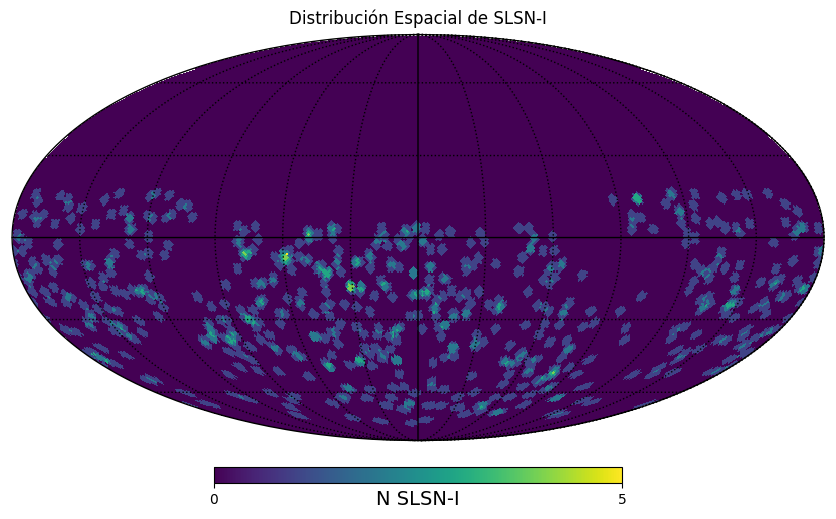

✅ ANÁLISIS ESPACIAL COMPLETADO:
   • Píxeles con SLSN-I: 7,474
   • Área cubierta: 6272.9 grados²
   • Densidad: 0.09 SLSN-I/grado²
   • SLSN-I más aislado: 5 por píxel


In [ ]:
print("🗺️ ANALIZANDO DISTRIBUCIÓN ESPACIAL...")

# Crear árbol espacial
coords = head_df[['rad_dec', 'rad_ra']].values
tree = BallTree(coords, metric='haversine')

# Configurar HEALPix
nside = 64
npix = hp.nside2npix(nside)

# Contar objetos por píxel
ipix = np.arange(npix)
hp_ra, hp_dec = np.radians(hp.pix2ang(nside, ipix, lonlat=True))

n_objects_per_pixel = tree.query_radius(
    np.column_stack([hp_dec, hp_ra]),
    r=np.radians(2.0),
    count_only=True
)

# Crear y visualizar mapa
sky_map = np.zeros(npix)
sky_map[ipix] = n_objects_per_pixel

plt.figure(figsize=(12, 6))
hp.mollview(sky_map, title="Distribución Espacial de SLSN-I", unit="N SLSN-I", min=0)
hp.graticule()
plt.show()

# Estadísticas espaciales
populated_pixels = np.sum(n_objects_per_pixel > 0)
total_area_deg2 = hp.nside2pixarea(nside, degrees=True) * populated_pixels

print("✅ ANÁLISIS ESPACIAL COMPLETADO:")
print(f"   • Píxeles con SLSN-I: {populated_pixels:,}")
print(f"   • Área cubierta: {total_area_deg2:.1f} grados²")
print(f"   • Densidad: {len(head_df)/total_area_deg2:.2f} SLSN-I/grado²")
print(f"   • SLSN-I más aislado: {np.max(n_objects_per_pixel)} por píxel")

## Analisis de redshifts

### Histograma de redshift final para SLSN-I

📊 GENERANDO HISTOGRAMA DE REDSHIFT_FINAL...


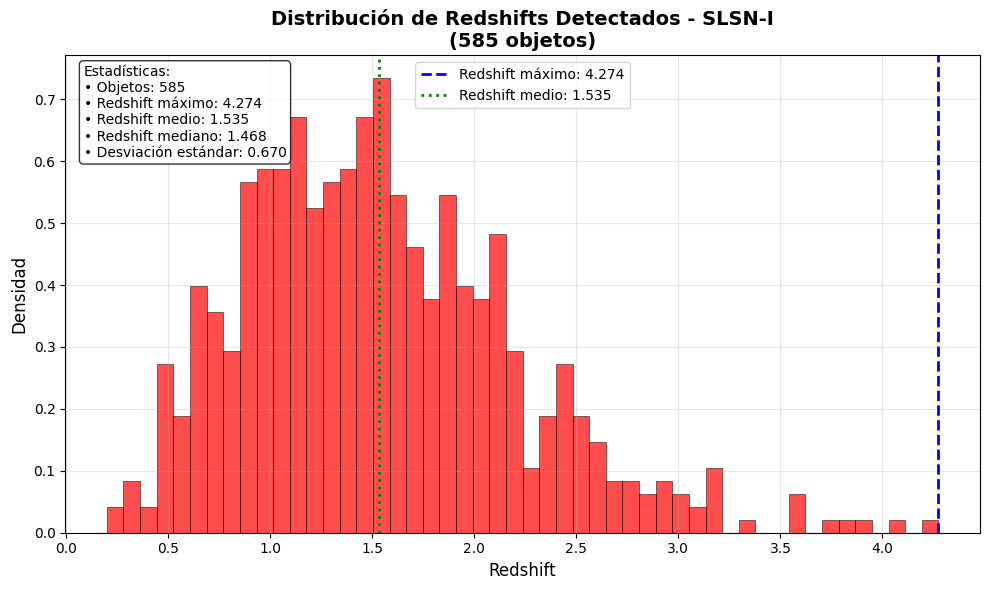

✅ Histograma de redshift_final generado


In [ ]:
print("📊 GENERANDO HISTOGRAMA DE REDSHIFT_FINAL...")

# Use the actual column name 'REDSHIFT_FINAL'
redshift_column = 'REDSHIFT_FINAL'

if redshift_column in head_df.columns:
    plt.figure(figsize=(10, 6))

    # Histograma de redshifts detectados
    n, bins, patches = plt.hist(
        head_df[redshift_column],
        bins=50,
        density=True,
        alpha=0.7,
        color='red',
        edgecolor='black',
        linewidth=0.5
    )

    # Línea vertical con redshift máximo
    max_redshift = head_df[redshift_column].max()
    plt.axvline(max_redshift, color='blue', linestyle='--', linewidth=2,
                label=f'Redshift máximo: {max_redshift:.3f}')

    # Estadísticas
    mean_redshift = head_df[redshift_column].mean()
    median_redshift = head_df[redshift_column].median()
    plt.axvline(mean_redshift, color='green', linestyle=':', linewidth=2,
                label=f'Redshift medio: {mean_redshift:.3f}')

    plt.xlabel('Redshift', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.title(f'Distribución de Redshifts Detectados - SLSN-I\n({len(head_df):,} objetos)',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir texto con estadísticas
    stats_text = f'''Estadísticas:
• Objetos: {len(head_df):,}
• Redshift máximo: {max_redshift:.3f}
• Redshift medio: {mean_redshift:.3f}
• Redshift mediano: {median_redshift:.3f}
• Desviación estándar: {head_df[redshift_column].std():.3f}'''

    plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✅ Histograma de redshift_final generado")
else:
    print(f"❌ Columna {redshift_column} no encontrada en HEAD")

### Histograma comparativo ZCMB- Simulado vs detectado

📊 GENERANDO HISTOGRAMA COMPARATIVO ZCMB...


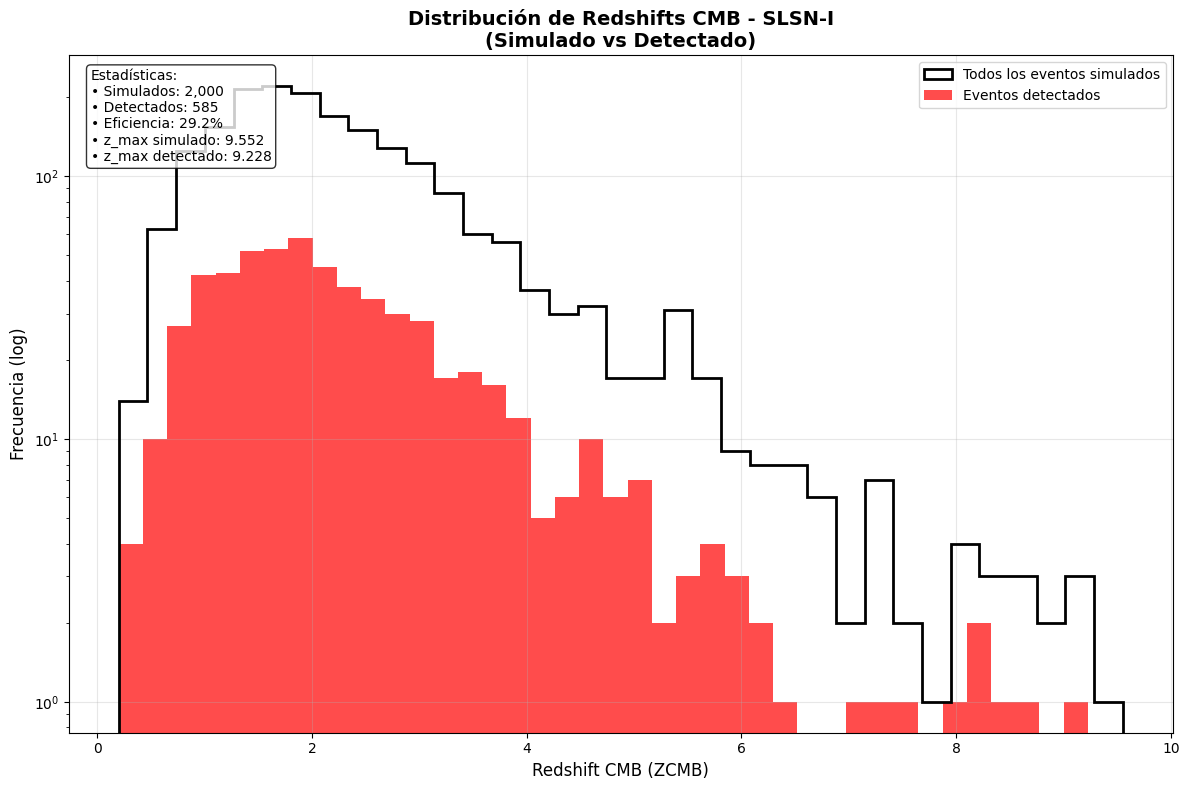

✅ Histograma comparativo ZCMB generado

📈 EFICIENCIA POR BIN DE REDSHIFT:
   • z = [0.00, 1.91): 30.4%
   • z = [1.91, 3.82): 29.0%
   • z = [3.82, 5.73): 26.8%
   • z = [5.73, 7.64): 20.4%
   • z = [7.64, 9.55): 37.5%


In [ ]:
print("📊 GENERANDO HISTOGRAMA COMPARATIVO ZCMB...")

# Buscar columnas ZCMB en DUMP
zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
sim_zcmb_col = zcmb_cols[0] if zcmb_cols else sim_z_col

if sim_zcmb_col and not dump_df.empty:
    # Crear máscara para eventos detectados
    detected_mask = dump_df.index.isin(head_df.index)

    plt.figure(figsize=(12, 8))

    # Histograma de todos los eventos simulados
    plt.hist(
        dump_df[sim_zcmb_col],
        bins=35,
        color='black',
        histtype='step',
        linewidth=2,
        label='Todos los eventos simulados',
        log=True
    )

    # Histograma de eventos detectados
    if detected_mask.any():
        plt.hist(
            dump_df[detected_mask][sim_zcmb_col],
            bins=40,
        color='red',
        alpha=0.7,
        label='Eventos detectados',
        log=True
    )

    plt.xlabel(f'Redshift CMB ({sim_zcmb_col})', fontsize=12)
    plt.ylabel('Frecuencia (log)', fontsize=12)
    plt.title('Distribución de Redshifts CMB - SLSN-I\n(Simulado vs Detectado)',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir estadísticas
    if detected_mask.any():
        stats_text = f'''Estadísticas:
• Simulados: {len(dump_df):,}
• Detectados: {detected_mask.sum():,}
• Eficiencia: {detected_mask.sum()/len(dump_df)*100:.1f}%
• z_max simulado: {dump_df[sim_zcmb_col].max():.3f}
• z_max detectado: {dump_df[detected_mask][sim_zcmb_col].max():.3f}'''

        plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
                     verticalalignment='top', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✅ Histograma comparativo ZCMB generado")

    # Calcular eficiencia por bin de redshift
    if detected_mask.any():
        print(f"\n📈 EFICIENCIA POR BIN DE REDSHIFT:")
        z_bins = np.linspace(0, dump_df[sim_zcmb_col].max(), 6)
        for i in range(len(z_bins)-1):
            bin_mask = (dump_df[sim_zcmb_col] >= z_bins[i]) & (dump_df[sim_zcmb_col] < z_bins[i+1])
            bin_detected = detected_mask & bin_mask
            efficiency = bin_detected.sum() / bin_mask.sum() * 100 if bin_mask.sum() > 0 else 0
            print(f"   • z = [{z_bins[i]:.2f}, {z_bins[i+1]:.2f}): {efficiency:.1f}%")

else:
    print("❌ No se puede generar histograma - faltan datos de ZCMB")

**Redshift Detectado (o Redshift Observado):**

Este es el redshift que medimos directamente a partir de la luz que nos llega de un objeto astronómico (como un SLSN-I, una galaxia, un cuásar, etc.).

Se determina observando el espectro de la luz del objeto y midiendo cuánto se han desplazado las líneas espectrales conocidas (líneas de emisión o absorción de elementos químicos) hacia longitudes de onda más largas (el lado rojo del espectro) en comparación con sus posiciones en el laboratorio.

Este desplazamiento es causado por una combinación de factores:

*La expansión del universo:*  Este es el componente principal y el más interesante para los cosmólogos, ya que nos dice qué tan lejos está el objeto y cuánto tiempo ha viajado su luz.

*El movimiento peculiar del objeto:* El movimiento real del objeto a través del espacio, además de la expansión del universo.

*El movimiento peculiar de la Tierra/Observador:* El movimiento de nuestro propio planeta alrededor del Sol, dentro de la Vía Láctea y hacia el "Gran Atractor".

El redshift detectado es, por lo tanto, una medida combinada de estas velocidades relativas.


**Redshift CMB (Redshift en el Marco de Reposo del Fondo Cósmico de Microondas):**

Este es un redshift corregido que intenta eliminar el efecto de los movimientos peculiares (tanto del objeto como del observador) para quedarse solo con el componente debido a la expansión pura del universo.

Se calcula tomando el redshift detectado y restándole las contribuciones estimadas de los movimientos peculiares. Para el movimiento peculiar del observador, se usa la velocidad de nuestro Sistema Solar con respecto al marco de referencia del Fondo Cósmico de Microondas (CMB), que se considera el "marco de reposo" del universo a gran escala.

El redshift CMB es particularmente útil en cosmología porque nos da una medida más directa de la distancia cosmológica del objeto, es decir, la distancia que se deriva únicamente de la expansión del espacio-tiempo.

Las simulaciones a menudo generan el redshift simulado en el marco de reposo del CMB (ZCMB) porque este es el valor "ideal" que refleja la posición del objeto en el universo en expansión, antes de que se añadan los efectos de los movimientos locales y del observador.

### Resumen completo de analisis de redshifts

In [ ]:
print("="*60)
print("📊 RESUMEN COMPLETO - ANÁLISIS DE REDSHIFTS SLSN-I")
print("="*60)

if not dump_df.empty and sim_zcmb_col and 'REDSHIFT_FINAL' in head_df.columns:
    # Estadísticas de detección
    detected_mask = dump_df.index.isin(head_df.index)

    print(f"🎯 ESTADÍSTICAS DE DETECCIÓN:")
    print(f"   • Eventos simulados totales: {len(dump_df):,}")
    print(f"   • Eventos detectados: {detected_mask.sum():,}")
    print(f"   • Eficiencia global: {detected_mask.sum()/len(dump_df)*100:.2f}%")

    print(f"\n📈 ESTADÍSTICAS DE REDSHIFT:")
    print(f"   • Redshift máximo simulado: {dump_df[sim_zcmb_col].max():.3f}")
    print(f"   • Redshift máximo detectado: {head_df['REDSHIFT_FINAL'].max():.3f}")
    print(f"   • Redshift medio detectado: {head_df['REDSHIFT_FINAL'].mean():.3f}")
    print(f"   • Redshift mediano detectado: {head_df['REDSHIFT_FINAL'].median():.3f}")

    # Eficiencia por rango de redshift
    print(f"\n📊 EFICIENCIA POR RANGO DE REDSHIFT:")
    z_ranges = [(0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, dump_df[sim_zcmb_col].max())]

    for z_min, z_max in z_ranges:
        if z_min < dump_df[sim_zcmb_col].max():
            range_mask = (dump_df[sim_zcmb_col] >= z_min) & (dump_df[sim_zcmb_col] < z_max)
            if range_mask.any():
                range_detected = detected_mask & range_mask
                efficiency = range_detected.sum() / range_mask.sum() * 100
                n_sim = range_mask.sum()
                n_det = range_detected.sum()
                print(f"   • z [{z_min:.1f}, {z_max:.1f}): {n_det}/{n_sim} = {efficiency:.1f}%")

    print(f"\n✅ ANÁLISIS DE REDSHIFTS COMPLETADO")
else:
    print("❌ No se pudo completar el análisis - faltan datos esenciales")

📊 RESUMEN COMPLETO - ANÁLISIS DE REDSHIFTS SLSN-I
🎯 ESTADÍSTICAS DE DETECCIÓN:
   • Eventos simulados totales: 2,000
   • Eventos detectados: 585
   • Eficiencia global: 29.25%

📈 ESTADÍSTICAS DE REDSHIFT:
   • Redshift máximo simulado: 9.552
   • Redshift máximo detectado: 4.274
   • Redshift medio detectado: 1.535
   • Redshift mediano detectado: 1.468

📊 EFICIENCIA POR RANGO DE REDSHIFT:
   • z [0.0, 0.5): 7/24 = 29.2%
   • z [0.5, 1.0): 61/177 = 34.5%
   • z [1.0, 1.5): 92/335 = 27.5%
   • z [1.5, 2.0): 126/415 = 30.4%
   • z [2.0, 9.6): 299/1048 = 28.5%

✅ ANÁLISIS DE REDSHIFTS COMPLETADO


## Numero de detecciones por SLSN-I

📊 ANALIZANDO Y GRAFICANDO NÚMERO DE DETECCIONES POR SLSN-I...
Procesando 585 objetos SLSN-I...
Generando histogramas...


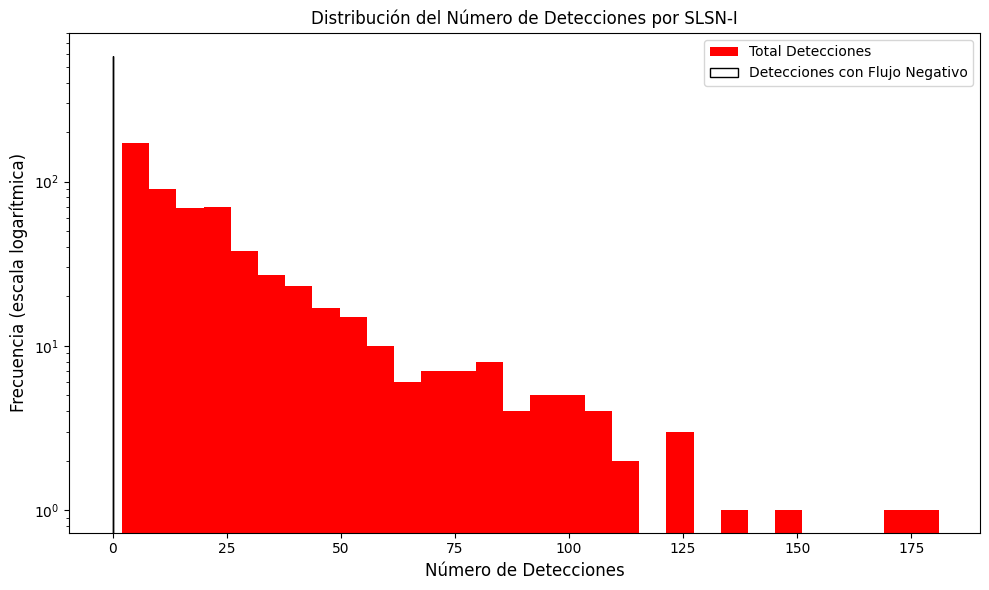

✅ Análisis y gráfico de número de detecciones completado.

=== ESTADÍSTICAS DE DETECCIONES ===
Número promedio de detecciones por SLSN-I: 24.75
Número promedio de detecciones con flujo negativo por SLSN-I: 0.00
AGN con más detecciones: 181
AGN con más detecciones de flujo negativo: 0


In [ ]:
print("📊 ANALIZANDO Y GRAFICANDO NÚMERO DE DETECCIONES POR SLSN-I...")

# Fundamento Astronómico:
# El número de detecciones para un objeto astronómico, especialmente un transiente como un AGN,
# es crucial para caracterizar su comportamiento a lo largo del tiempo. Un mayor número de
# detecciones a menudo implica una curva de luz mejor muestreada, lo que permite una mejor
# determinación de propiedades como la magnitud máxima, la duración del evento y los parámetros
# de variabilidad.
#
# Las detecciones con flujo negativo (FLUX_uJy < 0) son un indicador importante de ruido
# o problemas en el fondo del cielo (sky subtraction). Analizar su frecuencia y distribución
# nos ayuda a evaluar la calidad de la fotometría y a identificar posibles limitaciones
# en la capacidad de detección, especialmente para objetos débiles. Una alta tasa de
# detecciones con flujo negativo puede sugerir que el límite de detección es demasiado somero
# o que hay problemas sistemáticos en el procesamiento de las imágenes.

if not head_df.empty and not phot_df.empty:
    # Listas para almacenar el número de detecciones
    n_detecciones = []
    n_neg_flux = []

    print(f"Procesando {len(head_df)} objetos SLSN-I...")

    # Iterar sobre cada objeto SLSN-I en el DataFrame de metadatos (head_df)
    for index, obj_meta in head_df.iterrows():
        # Extraer el rango de observaciones para este objeto usando PTROBS_MIN y PTROBS_MAX
        # Restamos 1 a PTROBS_MIN porque los índices de pandas son base 0,
        # mientras que PTROBS_MIN/MAX en SNANA suelen ser base 1.
        # Aseguramos que los valores de índice son válidos para el DataFrame phot_df
        first_obs_idx = obj_meta['PTROBS_MIN'] - 1
        last_obs_idx = obj_meta['PTROBS_MAX']

        # Seleccionar las observaciones correspondientes a este objeto
        # Usamos iloc para seleccionar por índice de posición
        obj_obs = phot_df.iloc[first_obs_idx : last_obs_idx + 1]

        # Filtrar observaciones consideradas "detecciones"
        # Según la documentación de SNANA, PHOTFLAG = 4096 o 6144 indican una detección.
        # PHOTFLAG = 4096: Detection
        # PHOTFLAG = 6144: Detection (with some flag, e.g., saturated pixel)
        # Consideramos ambas como "detecciones" en este contexto.
        detections = obj_obs[(obj_obs['PHOTFLAG'] == 4096) | (obj_obs['PHOTFLAG'] == 6144)].copy()

        # Contar el número total de detecciones para este objeto
        n_detecciones.append(len(detections))

        # Contar el número de detecciones con flujo negativo
        neg_detections = detections[detections['FLUX_uJy'] < 0]
        n_neg_flux.append(len(neg_detections))

    # Convertir las listas a Series de pandas para facilitar el ploteo
    detections_series = pd.Series(n_detecciones, index=head_df.index)
    neg_flux_series = pd.Series(n_neg_flux, index=head_df.index)

    print("Generando histogramas...")

    # Crear figura y ejes para los histogramas
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histograma del número total de detecciones
    detections_series.hist(bins=30, density=False, ax=ax, grid=False, color='r', log=True, label='Total Detecciones')

    # Histograma del número de detecciones con flujo negativo (como un paso)
    # Usamos bins similares para una comparación visual más fácil
    neg_flux_series.hist(bins=30, ax=ax, grid=False, color='k', log=True, histtype='step', label='Detecciones con Flujo Negativo')


    # Configurar título y etiquetas del gráfico
    ax.set_title('Distribución del Número de Detecciones por SLSN-I', size='large', y=1.0)
    ax.set_xlabel('Número de Detecciones', size='large')
    ax.set_ylabel('Frecuencia (escala logarítmica)', size='large')
    ax.legend() # Mostrar la leyenda para identificar los histogramas

    # Ajustar diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

    print("✅ Análisis y gráfico de número de detecciones completado.")

    # Opcional: Imprimir algunas estadísticas resumen
    print("\n=== ESTADÍSTICAS DE DETECCIONES ===")
    print(f"Número promedio de detecciones por SLSN-I: {detections_series.mean():.2f}")
    print(f"Número promedio de detecciones con flujo negativo por SLSN-I: {neg_flux_series.mean():.2f}")
    print(f"AGN con más detecciones: {detections_series.max():.0f}")
    print(f"AGN con más detecciones de flujo negativo: {neg_flux_series.max():.0f}")


else:
    print("❌ No se pueden realizar análisis - head_df o phot_df están vacíos.")

## Histograma de magnitudes contrastado

La distribución de brillo de una población de objetos. Contrastar la distribución de magnitudes de todas las observaciones con la de las observaciones *detectadas* es fundamental para entender los sesgos de selección de un relevamiento.

La distribución de todas las observaciones (simuladas o reales) nos da una idea de la poblacion intrínseca y la contribución del ruido. La distribución de las observaciones *detectadas*, por otro lado, muestra qué parte de esa población es efectivamente visible con los criterios de detección aplicados. La diferencia entre ambas distribuciones revela la "función de selección" del relevamiento, mostrando a qué magnitudes se vuelve
incompleto o incapaz de detectar objetos.

Se espera ver que las detecciones se concentran en magnitudes más brillantes (valores de MAG_AB menores) en comparación con todas las observaciones, que pueden extenderse a magnitudes mucho más débiles (valores de MAG_AB mayores), a menudo dominadas por el ruido. La escala logarítmica en la frecuencia para las detecciones es útil para visualizar la cola de objetos más débiles detectados.

📊 GENERANDO HISTOGRAMA DE MAGNITUDES CONTRASTADO...


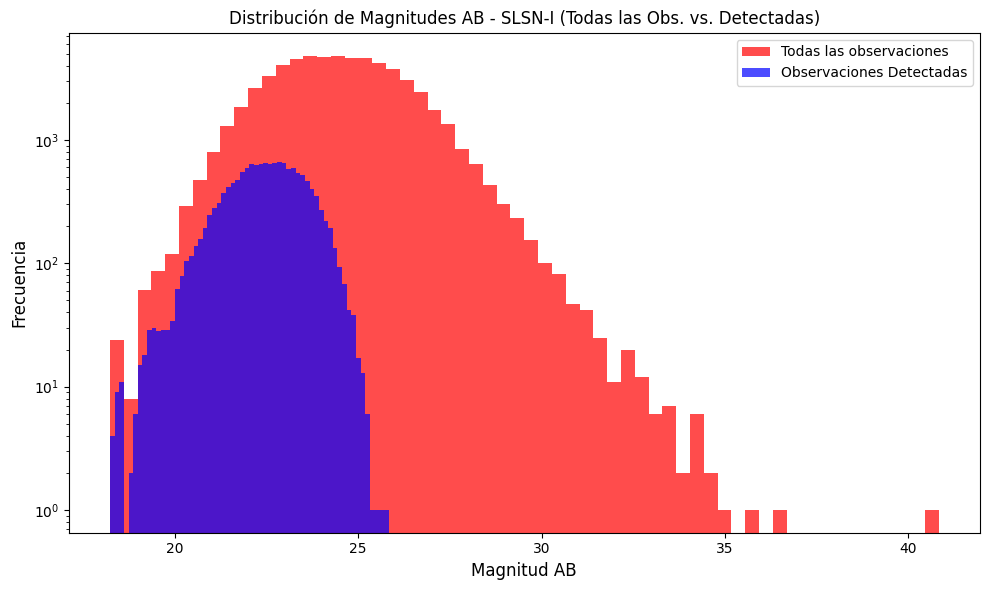

✅ Histograma de magnitudes contrastado generado.


In [ ]:
print("📊 GENERANDO HISTOGRAMA DE MAGNITUDES CONTRASTADO...")

if not phot_df.empty and 'MAG_AB' in phot_df.columns and 'PHOTFLAG' in phot_df.columns:
    # Crear figura y ejes para el histograma
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histograma de todas las observaciones (con magnitud válida)
    # Filtramos los NaN en MAG_AB para el histograma
    all_magnitudes = phot_df['MAG_AB'].dropna()
    if not all_magnitudes.empty:
        all_magnitudes.hist(bins=60, density=False, ax=ax, grid=False, color='r', alpha=0.7, label='Todas las observaciones')

    # Filtrar observaciones consideradas "detecciones"
    # Según la documentación de SNANA, PHOTFLAG = 4096 o 6144 indican una detección.
    detections_df = phot_df[(phot_df['PHOTFLAG'] == 4096) | (phot_df['PHOTFLAG'] == 6144)].copy()

    # Histograma de magnitudes de las detecciones (con magnitud válida)
    detected_magnitudes = detections_df['MAG_AB'].dropna()
    if not detected_magnitudes.empty:
        # Usamos los mismos bins para consistencia visual
        detected_magnitudes.hist(bins=60, density=False, ax=ax, grid=False, color='b', alpha=0.7, log=True, label='Observaciones Detectadas')


    # Configurar título y etiquetas
    ax.set_title('Distribución de Magnitudes AB - SLSN-I (Todas las Obs. vs. Detectadas)', size='large')
    ax.set_xlabel('Magnitud AB', size='large')
    ax.set_ylabel('Frecuencia', size='large') # Density=False means raw counts

    ax.legend()
    ax.grid(False) # Disable grid as in example
    # ax.invert_xaxis() # Magnitudes: más brillante = menor valor, so invert x-axis ***preguntar

    plt.tight_layout()
    plt.show()

    print("✅ Histograma de magnitudes contrastado generado.")

else:
    print("❌ No se pueden generar gráficos - phot_df vacío o faltan columnas esenciales ('MAG_AB', 'PHOTFLAG').")

# Curvas de luz

📈 GENERANDO CURVAS DE LUZ MEJORADAS...
🔍 Objetos seleccionados: 10 aleatorios


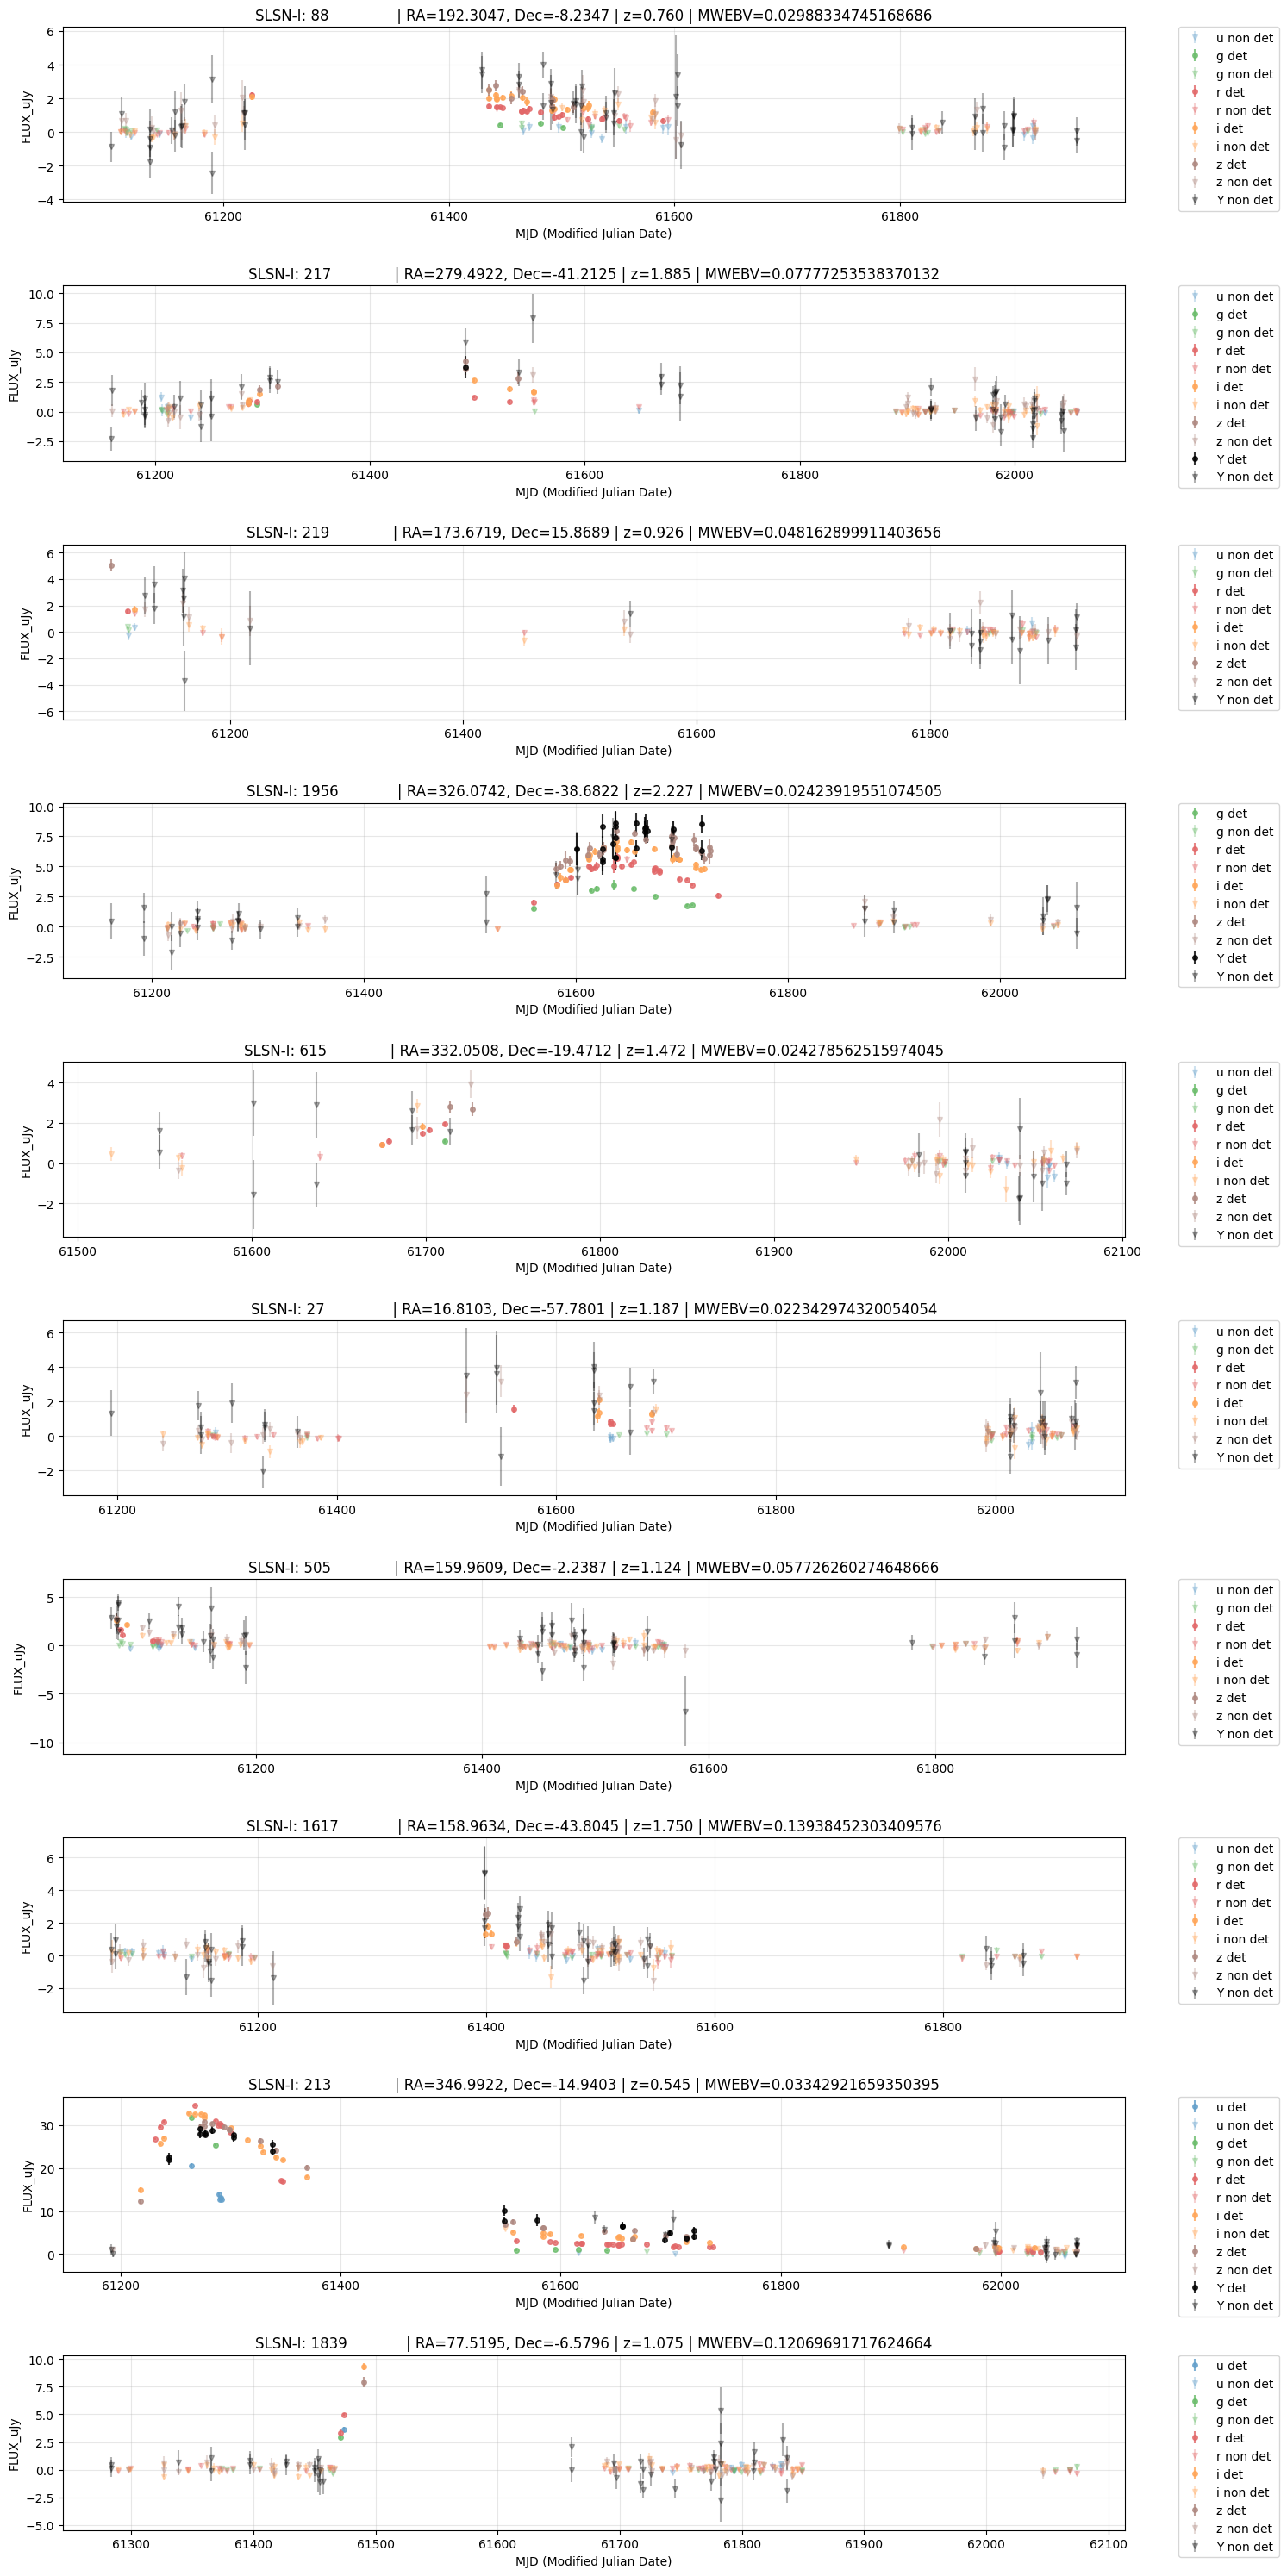

✅ CURVAS DE LUZ MEJORADAS GENERADAS


In [ ]:
print("📈 GENERANDO CURVAS DE LUZ MEJORADAS...")

# Select 10 random objects
n_objects_to_plot = 10
if len(head_df) >= n_objects_to_plot:
    # Select random objects
    selected_objects_meta = head_df.sample(n=n_objects_to_plot)
    top_objects = selected_objects_meta['SNID'].tolist()
    print(f"🔍 Objetos seleccionados: {len(top_objects)} aleatorios")

    # Define bands and colors based on user example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    # Adjusted figsize to make space for legends on the side
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Collect handles and labels for a single legend - Not needed anymore
    # handles, labels = [], []

    for i, snid in enumerate(top_objects):
        # Get object data using the helper function
        obj_data = linked_df[linked_df['SNID'] == snid].copy() # Use linked_df as it has SNID, RA, DEC, etc.

        # Get metadata for title
        obj_meta = head_df[head_df['SNID'] == snid].iloc[0]
        redshift = obj_meta['REDSHIFT_FINAL']
        ra = obj_meta['RA']
        dec = obj_meta['DEC']
        # Assuming MWEBV is in head_df, adjust column name if necessary
        mwebv = obj_meta.get('MWEBV', 'N/A') # Use .get to avoid error if MWEBV is missing


        for band in bands: # Iterate through defined bands
            band_data = obj_data[obj_data['BAND'] == band]

            # Separate detected and non-detected observations based on PHOTFLAG
            # PHOTFLAG = 4096 or 6144 for detections
            # PHOTFLAG = 0 for non-detections
            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            # Plot detected points (circles)
            if not detected_band_data.empty:
                # Changed back to errorbar and removed unpacking for detected points
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'], # Added yerr back for detected points too
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None' # No line for scatter points
                )
                # Collect handle and label only once - Not needed anymore
                # if f'{band} det' not in labels:
                #     handles.append(line)
                #     labels.append(f'{band} det')


            # Plot non-detected points (downward triangles) - Added yerr back and changed to errorbar
            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v', # downward triangle
                    markersize=4,
                    alpha=0.3, # reduced alpha for non-detections
                    linestyle='None' # No line for scatter points
                )
                 # Collect handle and label only once - Not needed anymore
                 # if f'{band} non det' not in labels:
                 #    handles.append(line)
                 #    labels.append(f'{band} non det')


        snid_str = snid.decode() if isinstance(snid, bytes) else snid
        axes[i].set_title(f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} |  z={redshift:.3f} | MWEBV={mwebv:.3f}' if isinstance(mwebv, (int, float)) else f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z={redshift:.3f} | MWEBV={mwebv}')
        axes[i].set_ylabel('FLUX_uJy')
        # Add legend outside the plot area
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)') # Set xlabel for each subplot


    # Removed the common x-label
    # axes[-1].set_xlabel('MJD (Modified Julian Date)')

    # Removed the single figure legend
    # fig.legend(handles, labels, loc='lower center', ncol=len(bands)*2, bbox_to_anchor=(0.5, -0.05))


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ MEJORADAS GENERADAS")
else:
    print(f"❌ No hay suficientes objetos ({len(head_df)}) para graficar {n_objects_to_plot}.")

## IDs de SLSN-I detectados

In [ ]:
print("🔍 OBTENIENDO SNID DE SLSN-I DETECTADOS...")

# Filtrar head_df para incluir solo los SNID presentes en linked_df
# linked_df contiene solo los objetos con observaciones vinculadas (que provienen de head_df)
# Un objeto en head_df se considera "detectado" en este contexto si tiene al menos una observación vinculada.
detected_snids_bytes = linked_df['SNID'].unique()

# Decodificar los SNID de bytes a string
detected_snids_str = [snid.decode().strip() for snid in detected_snids_bytes]

print(f"✅ Se encontraron {len(detected_snids_str):,} SNID de SLSN-I detectados.")

# Mostrar los primeros 10 SNID detectados
print("\n📋 Primeros 10 SNID detectados:")
print(detected_snids_str[:10])

# Guardar la lista de SNID detectados en una variable para uso posterior
detected_SLSN_snids = detected_snids_str

🔍 OBTENIENDO SNID DE SLSN-I DETECTADOS...
✅ Se encontraron 585 SNID de SLSN-I detectados.

📋 Primeros 10 SNID detectados:
['3', '5', '8', '11', '13', '14', '20', '21', '24', '25']


## Filtros exploratorios

In [ ]:
# =============================================================================
# FILTRADO DE SLSN-I DETECTADOS POR FLUJO MÍNIMO
# =============================================================================

print("🔍 Filtrando SLSN-I detectados por flujo mínimo...")

# Definir el umbral de flujo en microJy
flux_threshold_uJy = 20

# Crear una lista para almacenar los SNID que cumplen el criterio
snids_with_high_flux = []

# Iterar sobre cada SNID en la lista de detectados
# linked_df ya contiene solo los objetos detectados y sus observaciones vinculadas
# Optimización: Agrupar linked_df por SNID para un acceso más rápido a las observaciones de cada objeto
grouped_linked_df = linked_df.groupby('SNID')

print(f"Procesando {len(detected_SLSN_snids)} SLSN-I detectados...")

for snid_bytes in detected_snids_bytes: # Iterate over the original bytes list
    # Get all observations for the current SNID
    # Check if the SNID exists in the grouped DataFrame's keys before accessing
    if snid_bytes in grouped_linked_df.groups:
        obj_obs = grouped_linked_df.get_group(snid_bytes)

        # Verificar si alguna observación para este SNID tiene FLUX_uJy > flux_threshold_uJy
        if (obj_obs['FLUX_uJy'] > flux_threshold_uJy).any():
            # Decodificar el SNID de bytes a string antes de añadirlo a la lista final
            snids_with_high_flux.append(snid_bytes.decode().strip())


print(f"✅ Se encontraron {len(snids_with_high_flux):,} SLSN-I con al menos una medición > {flux_threshold_uJy} μJy.")

# Mostrar los primeros 10 SNID filtrados
print("\n📋 Primeros 10 SNID con alto flujo:")
print(snids_with_high_flux[:10])

# Guardar la lista filtrada en una nueva variable
filtered_SLSN_snids_high_flux = snids_with_high_flux

🔍 Filtrando SLSN-I detectados por flujo mínimo...
Procesando 585 SLSN-I detectados...
✅ Se encontraron 33 SLSN-I con al menos una medición > 20 μJy.

📋 Primeros 10 SNID con alto flujo:
['5', '8', '11', '31', '41', '131', '174', '213', '266', '321']


📈 GENERANDO CURVAS DE LUZ PARA SLSN-I CON ALTO FLUJO...
🔍 Objetos seleccionados para plotear: 33


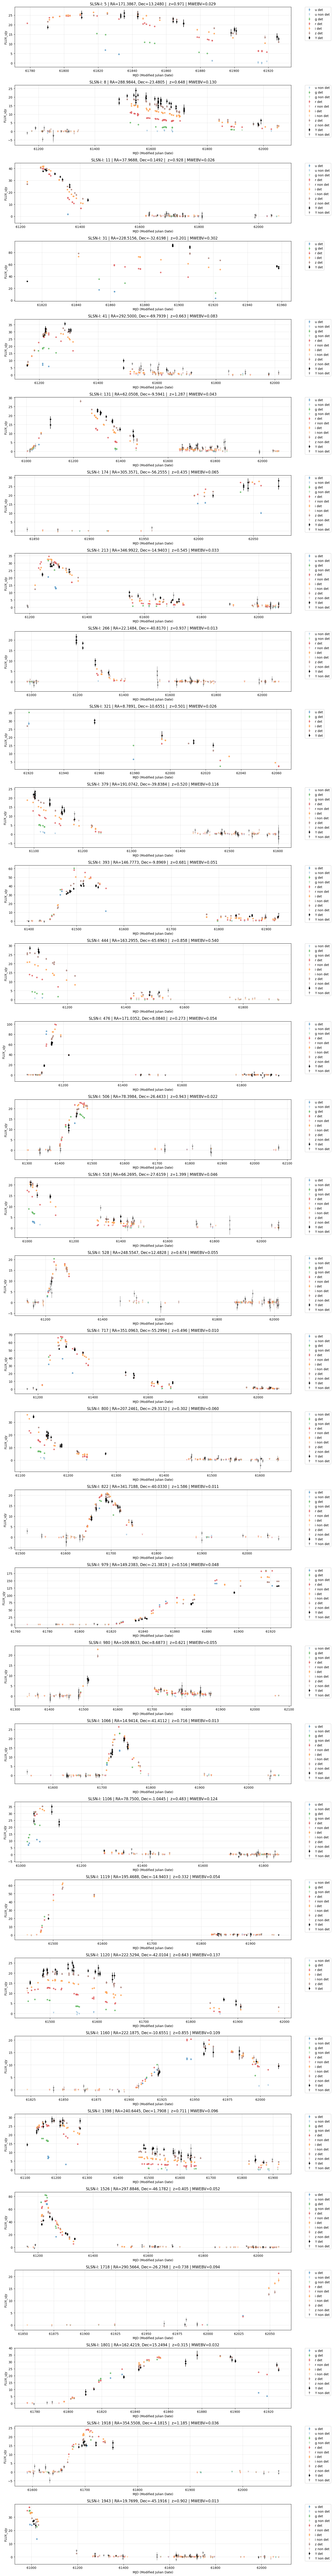

✅ CURVAS DE LUZ PARA SLSN-I CON ALTO FLUJO GENERADAS


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ PARA SLSN-I CON ALTO FLUJO
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ PARA SLSN-I CON ALTO FLUJO...")

# Use the list of SNIDs filtered by high flux
objects_to_plot_snids = filtered_SLSN_snids_high_flux # Use the filtered list
n_objects_to_plot = len(objects_to_plot_snids) # Update the count

if n_objects_to_plot > 0:
    # Get metadata for the selected objects based on their SNIDs
    # Need to handle byte strings for SNID in head_df if not already done
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    selected_objects_meta = head_df[head_df['SNID_str'].isin(objects_to_plot_snids)]

    # Ensure the plotting order matches the filtered list
    # Create a dictionary for quick lookup of metadata by SNID string
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')

    print(f"🔍 Objetos seleccionados para plotear: {n_objects_to_plot}")

    # Define bands and colors based on previous example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    # Adjusted figsize to make space for legends on the side
    # Adjusted height based on the number of objects
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3.5*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Iterate through the filtered SNIDs
    for i, snid_str in enumerate(objects_to_plot_snids):
        # Get object data using the helper function
        # Filter linked_df using the string SNID
        # Add 'SNID_str' to linked_df if not already present
        if 'SNID_str' not in linked_df.columns:
             linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

        obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy()

        # Get metadata for title using the dictionary lookup
        obj_meta = meta_dict.get(snid_str)
        if obj_meta is None:
             print(f"Metadata not found for SNID: {snid_str}")
             continue # Skip this object if metadata is missing

        redshift = obj_meta['REDSHIFT_FINAL']
        ra = obj_meta['RA']
        dec = obj_meta['DEC']
        mwebv = obj_meta.get('MWEBV', 'N/A')


        for band in bands: # Iterate through defined bands
            band_data = obj_data[obj_data['BAND'] == band]

            # Separate detected and non-detected observations based on PHOTFLAG
            # PHOTFLAG = 4096 or 6144 for detections
            # PHOTFLAG = 0 for non-detections
            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            # Plot detected points (circles)
            if not detected_band_data.empty:
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None'
                )


            # Plot non-detected points (downward triangles)
            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v',
                    markersize=4,
                    alpha=0.3,
                    linestyle='None'
                )


        axes[i].set_title(f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} |  z={redshift:.3f} | MWEBV={mwebv:.3f}' if isinstance(mwebv, (int, float)) else f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z={redshift:.3f} | MWEBV={mwebv}')
        axes[i].set_ylabel('FLUX_uJy')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)')


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ PARA SLSN-I CON ALTO FLUJO GENERADAS")
else:
    print(f"❌ No hay objetos en la lista filtrada para graficar.")

In [ ]:
# =============================================================================
# FILTRADO DE SLSN-I DETECTADOS POR REDSHIFT CMB (ZCMB) MÍNIMO
# =============================================================================

print("🔍 Filtrando SLSN-I detectados por Redshift CMB mínimo...")

# Definir el umbral de redshift CMB
zcmb_threshold = 3.5
# Asegurarse de que dump_df no esté vacío y que la columna ZCMB exista
zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
sim_zcmb_col = zcmb_cols[0] if zcmb_cols else None

if not dump_df.empty and sim_zcmb_col:
    # Asegurarse de que head_df tiene una columna string para SNID para facilitar la comparación
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    # Asegurarse de que dump_df tiene una columna string para SNID (o un índice que coincida con SNID_str)
    # Asumiendo que el índice de dump_df es el CID/SNID simulado
    # Si no es así, necesitaremos encontrar la columna que mapea a SNID.
    # Basado en la inspección inicial, parece que la columna 'CID' en DUMP corresponde a SNID.
    if 'CID' in dump_df.columns:
         dump_df['CID_str'] = dump_df['CID'].astype(str)
         # Crear un conjunto de SNID detectados como strings para una búsqueda rápida
         detected_snid_set = set(detected_SLSN_snids)

         # Filtrar dump_df para incluir solo los objetos que fueron detectados
         detected_in_dump_df = dump_df[dump_df['CID_str'].isin(detected_snid_set)].copy()

         # Ahora filtrar los objetos detectados por el umbral de ZCMB
         snids_high_zcmb_df = detected_in_dump_df[detected_in_dump_df[sim_zcmb_col] > zcmb_threshold]

         # Obtener la lista de SNID (como strings) que cumplen ambos criterios
         snids_high_zcmb = snids_high_zcmb_df['CID_str'].tolist()

         print(f"✅ Se encontraron {len(snids_high_zcmb):,} SLSN-I detectados con Redshift CMB > {zcmb_threshold}.")

         # Mostrar los primeros 10 SNID filtrados
         print("\n📋 Primeros 10 SNID con alto Redshift CMB:")
         print(snids_high_zcmb[:10])

         # Guardar la lista filtrada en una nueva variable
         filtered_SLSN_snids_high_zcmb = snids_high_zcmb

    else:
        print("❌ No se encontró la columna 'CID' en DUMP para vincular con SNID.")

else:
    print("❌ No se pudo realizar el filtrado - dump_df vacío o falta columna ZCMB.")

🔍 Filtrando SLSN-I detectados por Redshift CMB mínimo...
✅ Se encontraron 8 SLSN-I detectados con Redshift CMB > 3.5.

📋 Primeros 10 SNID con alto Redshift CMB:
['322', '389', '572', '726', '773', '1010', '1690', '1728']


📈 GENERANDO CURVAS DE LUZ PARA SLSN-I CON ALTO REDSHIFT CMB...
🔍 Objetos seleccionados para plotear: 8


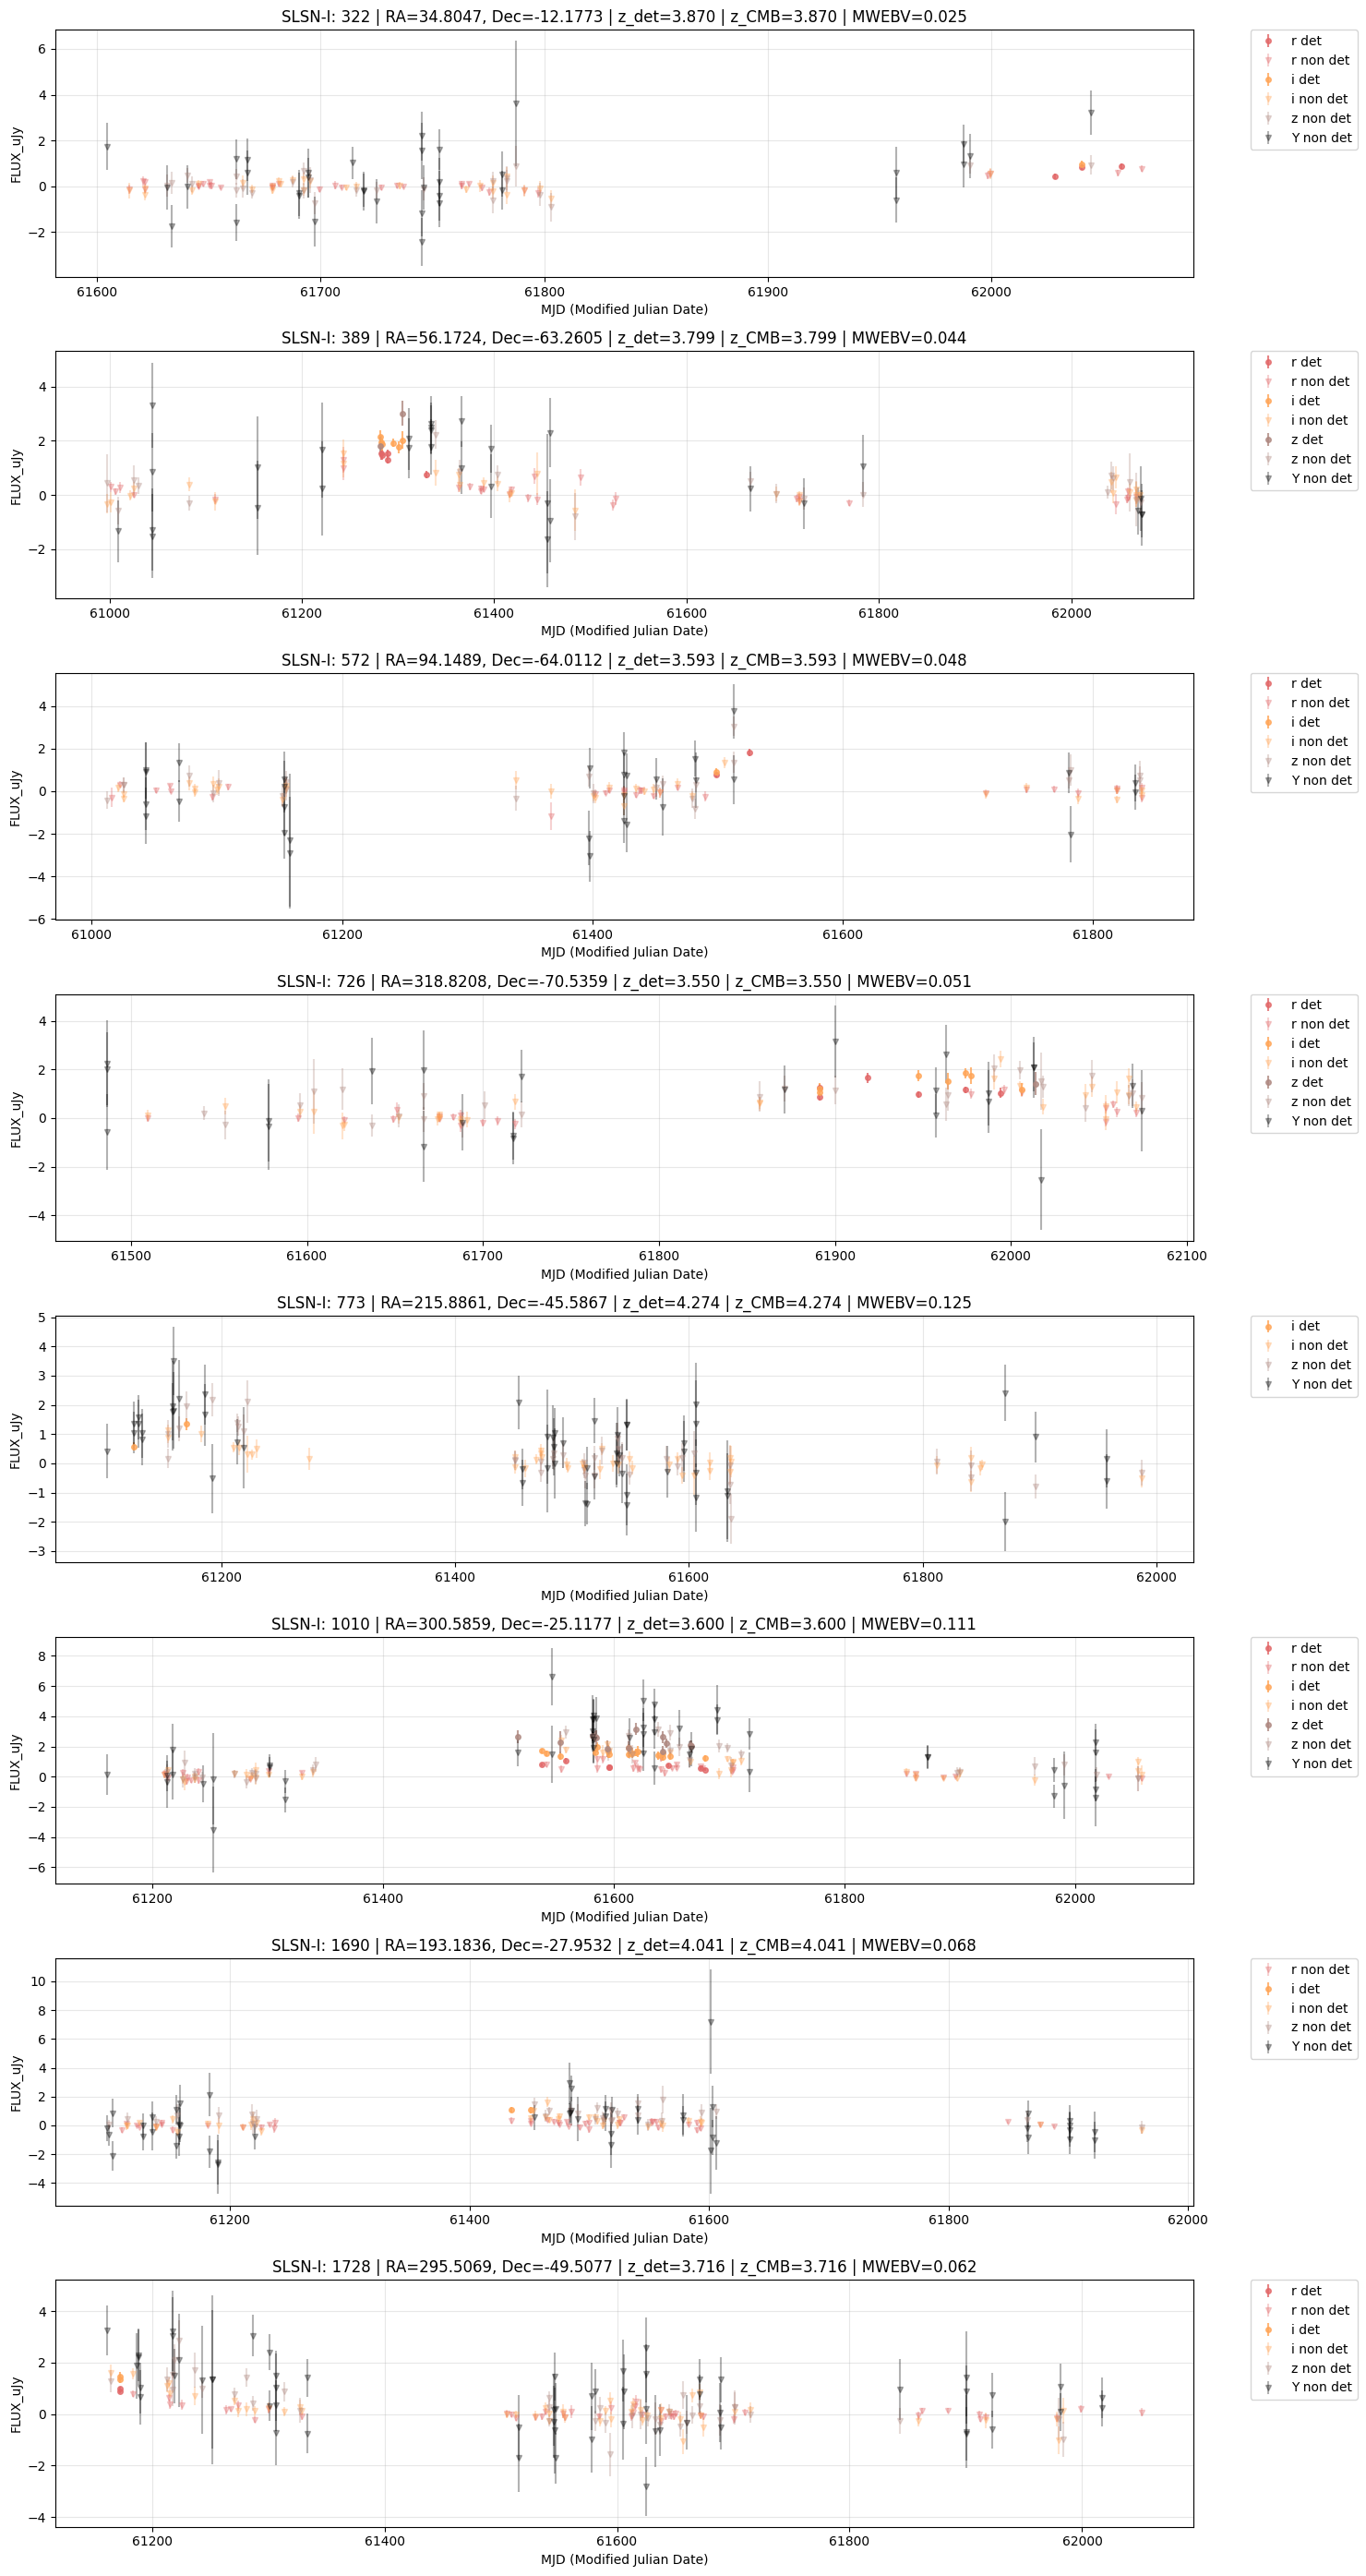

✅ CURVAS DE LUZ PARA SLSN-I CON ALTO REDSHIFT CMB GENERADAS


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ PARA SLSN-I CON ALTO REDSHIFT CMB
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ PARA SLSN-I CON ALTO REDSHIFT CMB...")

# Use the list of SNIDs filtered by high ZCMB
objects_to_plot_snids = filtered_SLSN_snids_high_zcmb # Use the filtered list
n_objects_to_plot = len(objects_to_plot_snids) # Update the count

if n_objects_to_plot > 0:
    # Get metadata for the selected objects based on their SNIDs
    # Ensure 'SNID_str' is in head_df
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    selected_objects_meta = head_df[head_df['SNID_str'].isin(objects_to_plot_snids)]

    # Ensure the plotting order matches the filtered list
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')

    print(f"🔍 Objetos seleccionados para plotear: {n_objects_to_plot}")

    # Define bands and colors based on previous example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    # Adjusted figsize and height based on the number of objects
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3.5*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Ensure 'SNID_str' is in linked_df
    if 'SNID_str' not in linked_df.columns:
         linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

    # Iterate through the filtered SNIDs
    for i, snid_str in enumerate(objects_to_plot_snids):
        # Get object data using the helper function
        obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy()

        # Get metadata for title using the dictionary lookup
        obj_meta = meta_dict.get(snid_str)
        if obj_meta is None:
             print(f"Metadata not found for SNID: {snid_str}")
             continue

        redshift = obj_meta['REDSHIFT_FINAL'] # Using detected redshift for plot title
        ra = obj_meta['RA']
        dec = obj_meta['DEC']
        mwebv = obj_meta.get('MWEBV', 'N/A')
        # Get ZCMB from dump_df for title if available
        zcmb_value = None
        zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
        sim_zcmb_col = zcmb_cols[0] if zcmb_cols else None
        if 'CID_str' in dump_df.columns and sim_zcmb_col and snid_str in dump_df['CID_str'].values:
             zcmb_row = dump_df[dump_df['CID_str'] == snid_str].iloc[0]
             zcmb_value = zcmb_row.get(sim_zcmb_col)


        for band in bands:
            band_data = obj_data[obj_data['BAND'] == band]

            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            if not detected_band_data.empty:
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None'
                )


            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v',
                    markersize=4,
                    alpha=0.3,
                    linestyle='None'
                )

        # Construct title including both detected redshift and ZCMB if available
        title_text = f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z_det={redshift:.3f}'
        if zcmb_value is not None:
             title_text += f' | z_CMB={zcmb_value:.3f}'
        if isinstance(mwebv, (int, float)):
             title_text += f' | MWEBV={mwebv:.3f}'
        else:
             title_text += f' | MWEBV={mwebv}'

        axes[i].set_title(title_text)
        axes[i].set_ylabel('FLUX_uJy')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)')


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ PARA SLSN-I CON ALTO REDSHIFT CMB GENERADAS")
else:
    print(f"❌ No hay objetos en la lista filtrada para graficar.")

🗺️ VISUALIZANDO UBICACIÓN DE SLSN-I ESPECÍFICO EN MAPA HEALPIX...
🔍 Ubicación de SNID 773: RA=215.8861, Dec=-45.5867


<Figure size 1200x600 with 0 Axes>

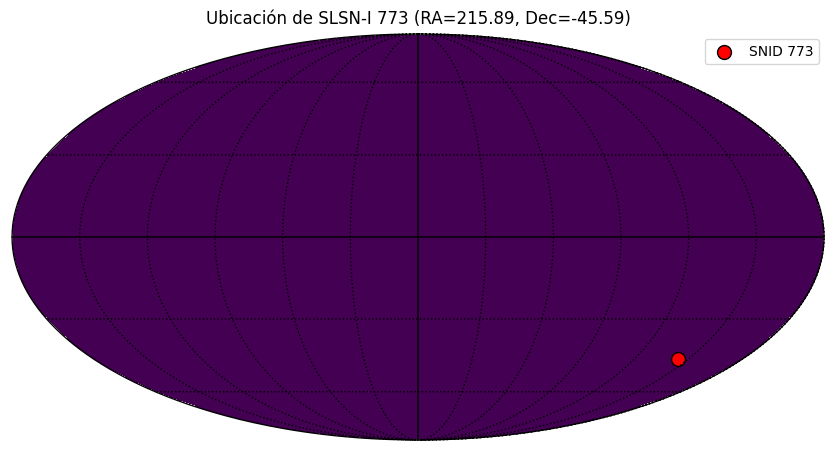

✅ Mapa HEALPix generado mostrando la ubicación de SNID 773.


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE LA UBICACIÓN DE UN SLSN-I ESPECÍFICO EN UN MAPA HEALPIX
# =============================================================================

print("🗺️ VISUALIZANDO UBICACIÓN DE SLSN-I ESPECÍFICO EN MAPA HEALPIX...")

# Definir el SNID del objeto que queremos visualizar
target_snid_str = '773'

# Asegurarse de que head_df tiene la columna string para SNID
if 'SNID_str' not in head_df.columns:
    head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

# Encontrar los metadatos para el objeto objetivo
target_object_meta = head_df[head_df['SNID_str'] == target_snid_str]

if not target_object_meta.empty:
    # Obtener RA y DEC del objeto objetivo
    target_ra = target_object_meta['RA'].iloc[0]
    target_dec = target_object_meta['DEC'].iloc[0]

    print(f"🔍 Ubicación de SNID {target_snid_str}: RA={target_ra:.4f}, Dec={target_dec:.4f}")


    # Configurar HEALPix (usando el mismo nside que antes para consistencia)
    nside = 64
    npix = hp.nside2npix(nside)

    # Crear un mapa HEALPix vacío
    sky_map_single = np.zeros(npix)

    # Convertir RA y DEC del objeto objetivo a coordenadas HEALPix (theta, phi)
    # healpy usa theta (colatitud) y phi (longitud), donde theta = 90 - Dec y phi = Ra
    target_theta = np.radians(90. - target_dec)
    target_phi = np.radians(target_ra)

    # Encontrar el píxel HEALPix que contiene el objeto objetivo
    target_pixel = hp.ang2pix(nside, target_theta, target_phi)

    # Marcar el píxel del objeto objetivo en el mapa (por ejemplo, con un valor de 1)
    sky_map_single[target_pixel] = 1.0

    # Visualizar el mapa
    plt.figure(figsize=(12, 6))
    hp.mollview(
        sky_map_single,
        title=f"Ubicación de SLSN-I {target_snid_str} (RA={target_ra:.2f}, Dec={target_dec:.2f})",
        unit="Pixel de Objeto Objetivo",
        min=0,
        max=1, # Escala para que solo se muestre el píxel marcado
        cbar=False # No necesitamos barra de color para un solo píxel
    )
    hp.graticule() # Añadir graticula para referencia

    # Añadir un marcador más visible en la ubicación exacta
    hp.projscatter(target_theta, target_phi, lonlat=False, marker='o', color='red', s=100, edgecolors='black', label=f'SNID {target_snid_str}')
    plt.legend(loc='best') # Add a legend for the marker


    plt.show()

    print(f"✅ Mapa HEALPix generado mostrando la ubicación de SNID {target_snid_str}.")

else:
    print(f"❌ SNID {target_snid_str} no encontrado en los metadatos.")

🗺️ VISUALIZANDO UBICACIÓN DE SLSN-I ESPECÍFICO EN MAPA HEALPIX...
🔍 Ubicación de SNID 1918: RA=354.5508, Dec=-4.1815


<Figure size 1200x600 with 0 Axes>

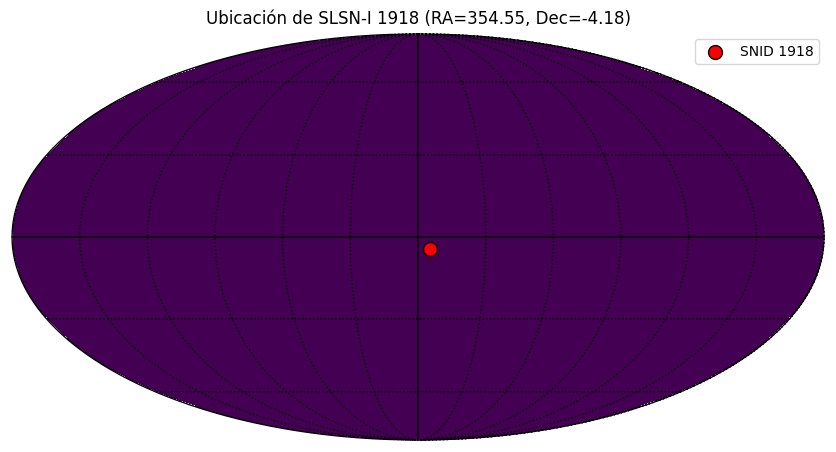

✅ Mapa HEALPix generado mostrando la ubicación de SNID 1918.


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE LA UBICACIÓN DE UN SLSN-I ESPECÍFICO EN UN MAPA HEALPIX
# =============================================================================

print("🗺️ VISUALIZANDO UBICACIÓN DE SLSN-I ESPECÍFICO EN MAPA HEALPIX...")

# Definir el SNID del objeto que queremos visualizar
target_snid_str = '1918'

# Asegurarse de que head_df tiene la columna string para SNID
if 'SNID_str' not in head_df.columns:
    head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

# Encontrar los metadatos para el objeto objetivo
target_object_meta = head_df[head_df['SNID_str'] == target_snid_str]

if not target_object_meta.empty:
    # Obtener RA y DEC del objeto objetivo
    target_ra = target_object_meta['RA'].iloc[0]
    target_dec = target_object_meta['DEC'].iloc[0]

    print(f"🔍 Ubicación de SNID {target_snid_str}: RA={target_ra:.4f}, Dec={target_dec:.4f}")


    # Configurar HEALPix (usando el mismo nside que antes para consistencia)
    nside = 64
    npix = hp.nside2npix(nside)

    # Crear un mapa HEALPix vacío
    sky_map_single = np.zeros(npix)

    # Convertir RA y DEC del objeto objetivo a coordenadas HEALPix (theta, phi)
    # healpy usa theta (colatitud) y phi (longitud), donde theta = 90 - Dec y phi = Ra
    target_theta = np.radians(90. - target_dec)
    target_phi = np.radians(target_ra)

    # Encontrar el píxel HEALPix que contiene el objeto objetivo
    target_pixel = hp.ang2pix(nside, target_theta, target_phi)

    # Marcar el píxel del objeto objetivo en el mapa (por ejemplo, con un valor de 1)
    sky_map_single[target_pixel] = 1.0

    # Visualizar el mapa
    plt.figure(figsize=(12, 6))
    hp.mollview(
        sky_map_single,
        title=f"Ubicación de SLSN-I {target_snid_str} (RA={target_ra:.2f}, Dec={target_dec:.2f})",
        unit="Pixel de Objeto Objetivo",
        min=0,
        max=1, # Escala para que solo se muestre el píxel marcado
        cbar=False # No necesitamos barra de color para un solo píxel
    )
    hp.graticule() # Añadir graticula para referencia

    # Añadir un marcador más visible en la ubicación exacta
    hp.projscatter(target_theta, target_phi, lonlat=False, marker='o', color='red', s=100, edgecolors='black', label=f'SNID {target_snid_str}')
    plt.legend(loc='best') # Add a legend for the marker


    plt.show()

    print(f"✅ Mapa HEALPix generado mostrando la ubicación de SNID {target_snid_str}.")

else:
    print(f"❌ SNID {target_snid_str} no encontrado en los metadatos.")

🗺️ COMPARANDO DISTRIBUCIÓN ESPACIAL (SIMULADOS vs DETECTADOS)...
Procesando todos los objetos simulados...
Procesando objetos detectados...
Generando mapas HEALPix...


/tmp/ipython-input-3754161348.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


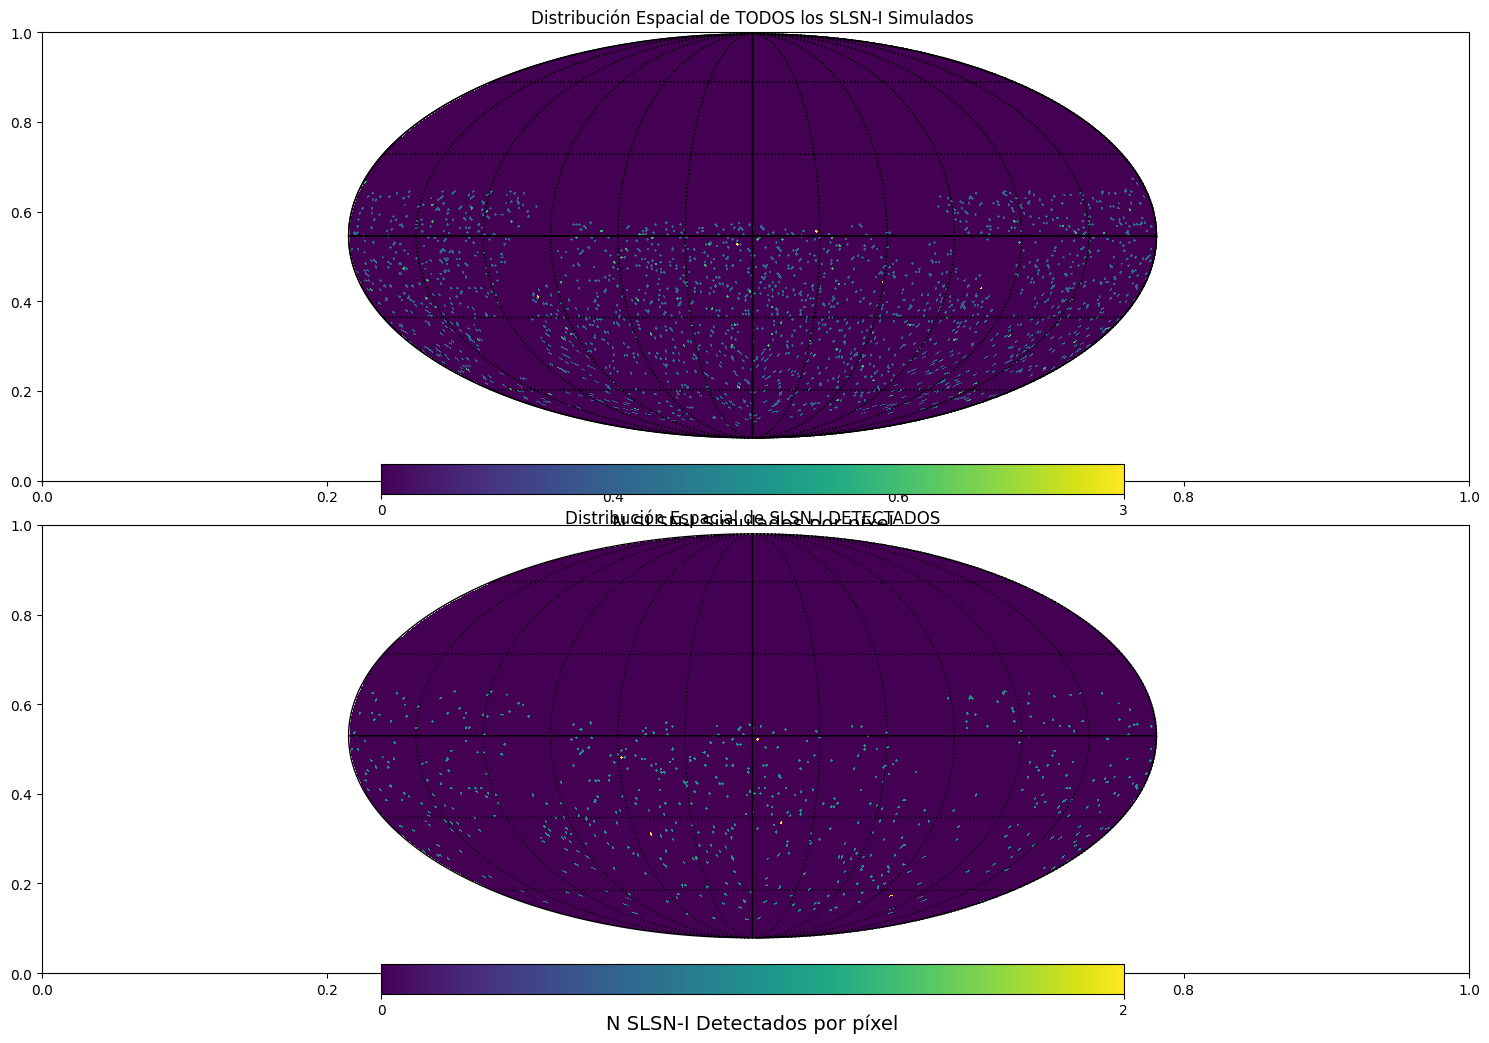

✅ Comparación de distribución espacial generada.


In [ ]:
# =============================================================================
# COMPARACIÓN DE DISTRIBUCIÓN ESPACIAL: SIMULADOS vs DETECTADOS (HEALPIX)
# =============================================================================

print("🗺️ COMPARANDO DISTRIBUCIÓN ESPACIAL (SIMULADOS vs DETECTADOS)...")

# Configurar HEALPix (usando el mismo nside que antes para consistencia)
nside = 64
npix = hp.nside2npix(nside)

# --- Mapa para TODOS los objetos SIMULADOS (desde DUMP) ---
sim_ra_col = [col for col in dump_df.columns if 'RA' in col.upper()][0] if [col for col in dump_df.columns if 'RA' in col.upper()] else None
sim_dec_col = [col for col in dump_df.columns if 'DEC' in col.upper()][0] if [col for col in dump_df.columns if 'DEC' in col.upper()] else None

if not dump_df.empty and sim_ra_col and sim_dec_col:
    print("Procesando todos los objetos simulados...")
    # Convertir RA y DEC de todos los simulados a coordenadas HEALPix
    sim_theta = np.radians(90. - dump_df[sim_dec_col])
    sim_phi = np.radians(dump_df[sim_ra_col])
    sim_pixels = hp.ang2pix(nside, sim_theta, sim_phi)

    # Contar objetos por píxel para todos los simulados
    sim_sky_map = np.bincount(sim_pixels, minlength=npix)

    # --- Mapa para objetos DETECTADOS (desde HEAD) ---
    # head_df ya tiene 'RA' y 'DEC'
    print("Procesando objetos detectados...")
    # Convertir RA y DEC de los detectados a coordenadas HEALPix
    det_theta = np.radians(90. - head_df['DEC'])
    det_phi = np.radians(head_df['RA'])
    det_pixels = hp.ang2pix(nside, det_theta, det_phi)

    # Contar objetos por píxel para los detectados
    det_sky_map = np.bincount(det_pixels, minlength=npix)

    # --- Visualización ---
    print("Generando mapas HEALPix...")
    plt.figure(figsize=(15, 10))

    # Subplot para todos los simulados
    plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
    hp.mollview(
        sim_sky_map,
        fig=plt.gcf(), # Use current figure
        sub=211,     # Subplot code
        title="Distribución Espacial de TODOS los SLSN-I Simulados",
        unit="N SLSN-I Simulados por píxel",
        min=0
    )
    hp.graticule()

    # Subplot para los detectados
    plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
    hp.mollview(
        det_sky_map,
        fig=plt.gcf(), # Use current figure
        sub=212,     # Subplot code
        title="Distribución Espacial de SLSN-I DETECTADOS",
        unit="N SLSN-I Detectados por píxel",
        min=0
    )
    hp.graticule()

    plt.tight_layout()
    plt.show()

    print("✅ Comparación de distribución espacial generada.")

else:
    print("❌ No se pudieron generar los mapas - faltan datos esenciales en DUMP o HEAD.")

🗺️ VISUALIZANDO UBICACIONES DE SLSN-I CON ALTO FLUJO EN MAPA HEALPIX...
✅ Marcador añadido para SNID 1918 (RA=354.55, Dec=-4.18).


<Figure size 1200x600 with 0 Axes>

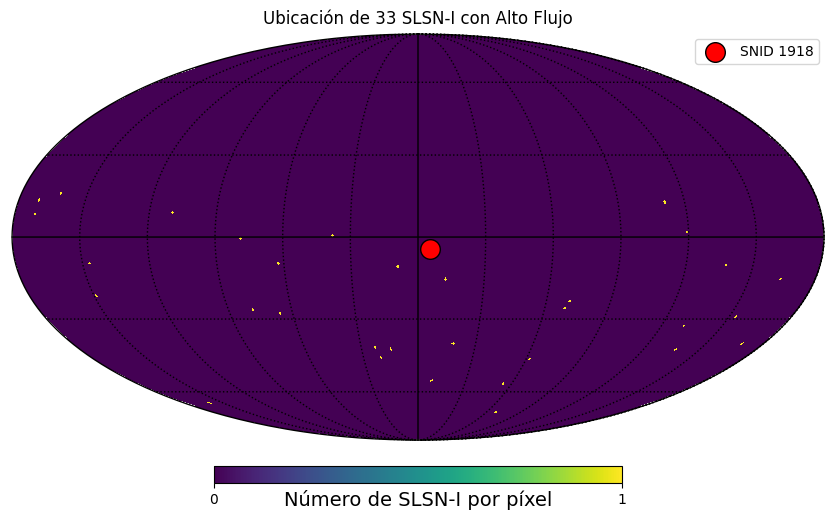

✅ Mapa HEALPix generado mostrando las ubicaciones de 33 SLSN-I con alto flujo.


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE LA UBICACIÓN DE MÚLTIPLES SLSN-I EN UN MAPA HEALPIX
# =============================================================================

print("🗺️ VISUALIZANDO UBICACIONES DE SLSN-I CON ALTO FLUJO EN MAPA HEALPIX...")

# Usar la lista de SNID filtrados por alto flujo
objects_to_plot_snids = filtered_SLSN_snids_high_flux # Usar la lista filtrada
n_objects_to_plot = len(objects_to_plot_snids) # Actualizar el contador

if n_objects_to_plot > 0:
    # Asegurarse de que head_df tiene la columna string para SNID
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    # Obtener los metadatos para los objetos objetivo (los de alto flujo)
    target_objects_meta = head_df[head_df['SNID_str'].isin(objects_to_plot_snids)].copy()

    if not target_objects_meta.empty:
        # Configurar HEALPix (usando el mismo nside que antes para consistencia)
        nside = 64
        npix = hp.nside2npix(nside)

        # Crear un mapa HEALPix vacío para la visualización de ubicaciones
        sky_map_locations = np.zeros(npix)

        # Convertir RA y DEC de los objetos objetivo a coordenadas HEALPix (theta, phi)
        target_theta = np.radians(90. - target_objects_meta['DEC'])
        target_phi = np.radians(target_objects_meta['RA'])

        # Encontrar los píxeles HEALPix que contienen los objetos objetivo
        target_pixels = hp.ang2pix(nside, target_theta, target_phi)

        # Incrementar el contador para cada píxel que contiene un objeto
        # Nota: Si múltiples objetos caen en el mismo píxel, este método los cuenta.
        for pixel in target_pixels:
            sky_map_locations[pixel] += 1

        # Visualizar el mapa
        plt.figure(figsize=(12, 6))
        hp.mollview(
            sky_map_locations,
            title=f"Ubicación de {n_objects_to_plot} SLSN-I con Alto Flujo",
            unit="Número de SLSN-I por píxel",
            min=0,
            cbar=True # Mostrar barra de color
        )
        hp.graticule() # Añadir graticula para referencia

        # --- Añadir la ubicación de la supernova 1918 ---
        specific_snid_str = '1918'
        specific_object_meta = head_df[head_df['SNID_str'] == specific_snid_str]

        if not specific_object_meta.empty:
            specific_ra = specific_object_meta['RA'].iloc[0]
            specific_dec = specific_object_meta['DEC'].iloc[0]
            specific_theta = np.radians(90. - specific_dec)
            specific_phi = np.radians(specific_ra)

            # Añadir un marcador para la supernova 1918
            hp.projscatter(specific_theta, specific_phi, lonlat=False, marker='o', color='red', s=200, edgecolors='black', label=f'SNID {specific_snid_str}')
            plt.legend(loc='best') # Añadir leyenda para el marcador

            print(f"✅ Marcador añadido para SNID {specific_snid_str} (RA={specific_ra:.2f}, Dec={specific_dec:.2f}).")
        else:
            print(f"❌ SNID {specific_snid_str} no encontrado en los metadatos.")


        plt.show()

        print(f"✅ Mapa HEALPix generado mostrando las ubicaciones de {n_objects_to_plot} SLSN-I con alto flujo.")

    else:
        print(f"❌ No se encontraron metadatos para los {n_objects_to_plot} SNID de alto flujo.")

else:
    print(f"❌ No hay objetos en la lista filtrada (alto flujo) para graficar.")

🗺️ VISUALIZANDO UBICACIONES DE SLSN-I ESPECÍFICOS EN EL MAPA DE TODOS LOS SIMULADOS...
Procesando todos los objetos simulados...
🔍 Marcando las ubicaciones de los SNID: ['1918', '773', '822'] con colores diferentes
✅ Marcadores añadidos para los SNID especificados con colores diferentes.


<Figure size 1200x600 with 0 Axes>

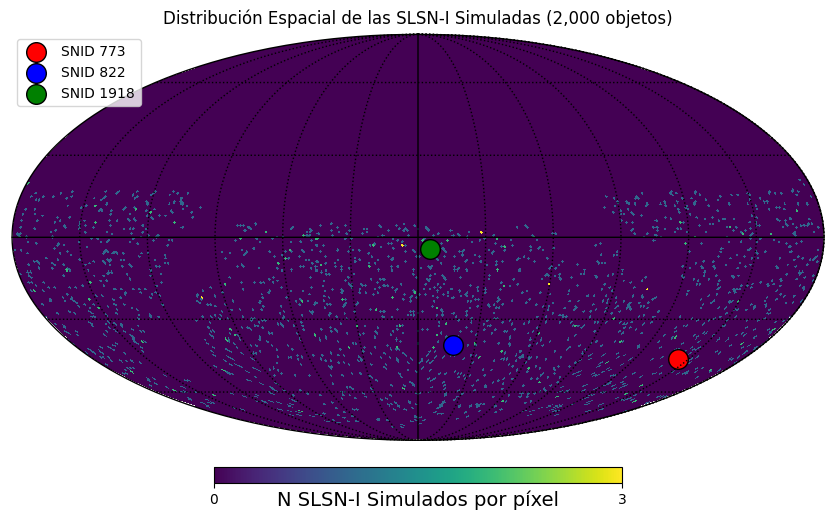

✅ Mapa HEALPix de todos los simulados con ubicaciones específicas (colores diferentes) generado.


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE LA UBICACIÓN DE MÚLTIPLES SLSN-I ESPECÍFICOS EN EL MAPA DE TODOS LOS SIMULADOS (HEALPIX)
# =============================================================================

print("🗺️ VISUALIZANDO UBICACIONES DE SLSN-I ESPECÍFICOS EN EL MAPA DE TODOS LOS SIMULADOS...")

# Configurar HEALPix (usando el mismo nside que antes para consistencia)
nside = 64
npix = hp.nside2npix(nside)

# --- Mapa para TODOS los objetos SIMULADOS (desde DUMP) ---
sim_ra_col = [col for col in dump_df.columns if 'RA' in col.upper()][0] if [col for col in dump_df.columns if 'RA' in col.upper()] else None
sim_dec_col = [col for col in dump_df.columns if 'DEC' in col.upper()][0] if [col for col in dump_df.columns if 'DEC' in col.upper()] else None
sim_cid_col = [col for col in dump_df.columns if 'CID' in col.upper()][0] if [col for col in dump_df.columns if 'CID' in col.upper()] else None


if not dump_df.empty and sim_ra_col and sim_dec_col and sim_cid_col:
    print("Procesando todos los objetos simulados...")
    # Convertir RA y DEC de todos los simulados a coordenadas HEALPix
    sim_theta = np.radians(90. - dump_df[sim_dec_col])
    sim_phi = np.radians(dump_df[sim_ra_col])
    sim_pixels = hp.ang2pix(nside, sim_theta, sim_phi)

    # Contar objetos por píxel para todos los simulados
    sim_sky_map = np.bincount(sim_pixels, minlength=npix)

    # --- Visualización ---
    plt.figure(figsize=(12, 6))
    hp.mollview(
        sim_sky_map,
        title=f"Distribución Espacial de las SLSN-I Simuladas ({len(dump_df):,} objetos)",
        unit="N SLSN-I Simulados por píxel",
        min=0,
        cbar=True # Mostrar barra de color
    )
    hp.graticule() # Añadir graticula para referencia

    # --- Añadir las ubicaciones de las supernovas específicas con colores diferentes ---
    target_snids_str = ['1918', '773','822']
    # Define a list of distinct colors for the markers
    marker_colors = ['red', 'blue', 'green', 'purple'] # Add more colors if needed

    # Asegurarse de que dump_df tiene una columna string para CID (SNID simulado)
    if 'CID_str' not in dump_df.columns:
         dump_df['CID_str'] = dump_df[sim_cid_col].astype(str)


    # Encontrar los metadatos para los objetos objetivo en DUMP
    target_objects_meta_dump = dump_df[dump_df['CID_str'].isin(target_snids_str)]

    if not target_objects_meta_dump.empty:
        print(f"🔍 Marcando las ubicaciones de los SNID: {target_snids_str} con colores diferentes")
        # Iterar sobre cada objeto objetivo encontrado y asignar un color
        for i, (index, obj_meta_dump) in enumerate(target_objects_meta_dump.iterrows()):
            # Obtener RA y DEC del objeto objetivo desde DUMP
            target_ra_dump = obj_meta_dump[sim_ra_col]
            target_dec_dump = obj_meta_dump[sim_dec_col]
            snid = obj_meta_dump['CID_str']
            color = marker_colors[i % len(marker_colors)] # Cycle through colors

            # Convertir a coordenadas HEALPix
            target_theta_dump = np.radians(90. - target_dec_dump)
            target_phi_dump = np.radians(target_ra_dump)

            # Añadir un marcador para cada supernova con su color asignado
            hp.projscatter(target_theta_dump, target_phi_dump, lonlat=False, marker='o', color=color, s=200, edgecolors='black', label=f'SNID {snid}')

        plt.legend(loc='best') # Añadir leyenda para los marcadores


        print(f"✅ Marcadores añadidos para los SNID especificados con colores diferentes.")
    else:
        print(f"❌ Ninguno de los SNID especificados ({target_snids_str}) fue encontrado en los datos simulados (DUMP).")


    plt.show()

    print("✅ Mapa HEALPix de todos los simulados con ubicaciones específicas (colores diferentes) generado.")

else:
    print("❌ No se pudo generar el mapa - faltan datos esenciales en DUMP.")

📈 GENERANDO CURVAS DE LUZ PARA SLSN-I ESPECÍFICOS...
🔍 Objetos seleccionados para plotear: 2


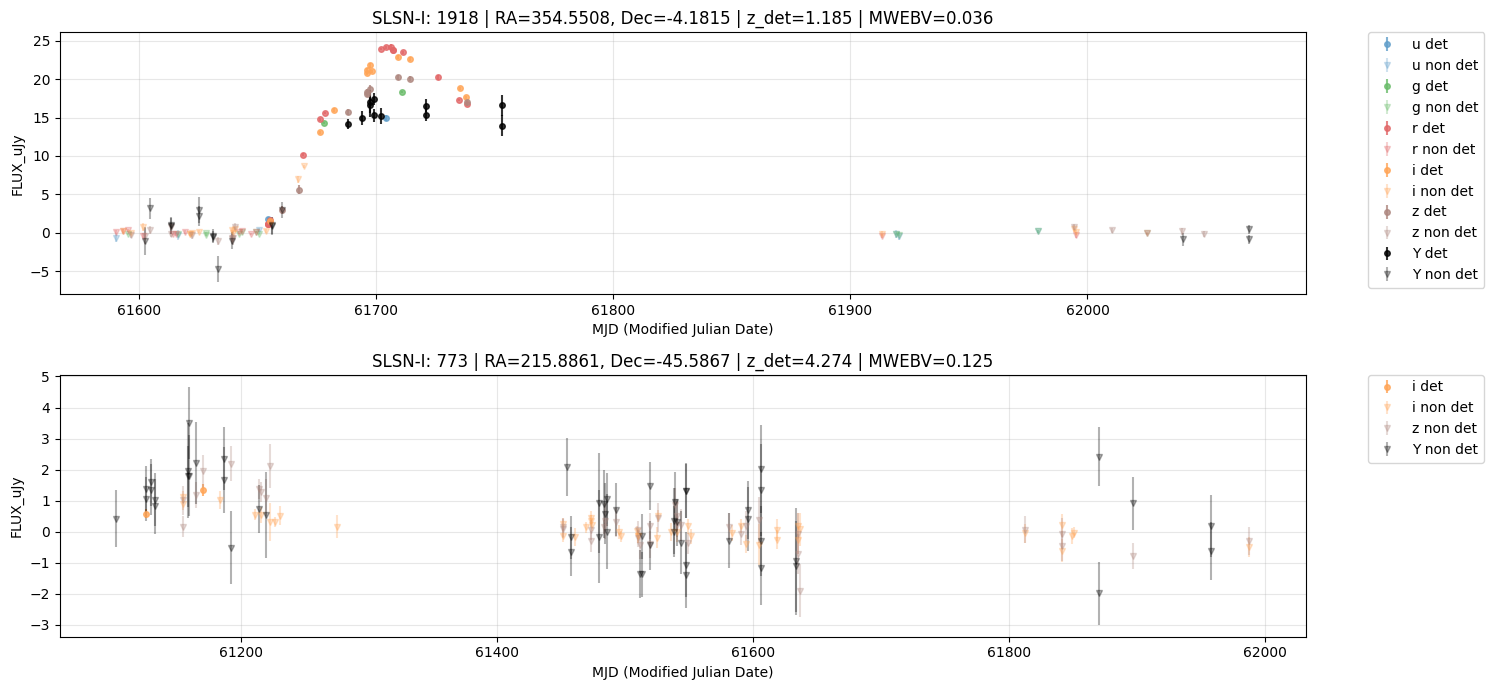

✅ Curvas de luz para SLSN-I específicos generadas.


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ PARA SLSN-I ESPECÍFICOS
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ PARA SLSN-I ESPECÍFICOS...")

# Definir los SNID de los objetos que queremos visualizar
target_snids_str = ['1918', '773']
n_objects_to_plot = len(target_snids_str)

if n_objects_to_plot > 0:
    # Get metadata for the selected objects based on their SNIDs
    # Ensure 'SNID_str' is in head_df
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    selected_objects_meta = head_df[head_df['SNID_str'].isin(target_snids_str)]

    # Ensure the plotting order matches the target list
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')

    print(f"🔍 Objetos seleccionados para plotear: {n_objects_to_plot}")

    # Define bands and colors based on previous example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3.5*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Ensure 'SNID_str' is in linked_df
    if 'SNID_str' not in linked_df.columns:
         linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

    # Iterate through the target SNIDs
    for i, snid_str in enumerate(target_snids_str):
        # Get object data using the helper function
        obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy()

        # Get metadata for title using the dictionary lookup
        obj_meta = meta_dict.get(snid_str)
        if obj_meta is None:
             print(f"Metadata not found for SNID: {snid_str}")
             continue

        redshift = obj_meta.get('REDSHIFT_FINAL', 'N/A') # Using detected redshift for plot title
        ra = obj_meta.get('RA', 'N/A')
        dec = obj_meta.get('DEC', 'N/A')
        mwebv = obj_meta.get('MWEBV', 'N/A')
        # Get ZCMB from dump_df for title if available
        zcmb_value = None
        zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
        sim_zcmb_col = zcmb_cols[0] if zcmb_cols else None
        if 'CID_str' in dump_df.columns and sim_zcmb_col and snid_str in dump_df['CID_str'].values:
             zcmb_row = dump_df[dump_df['CID_str'] == snid_str].iloc[0]
             zcmb_value = zcmb_row.get(sim_zcmb_col)


        for band in bands:
            band_data = obj_data[obj_data['BAND'] == band]

            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            if not detected_band_data.empty:
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None'
                )


            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v',
                    markersize=4,
                    alpha=0.3,
                    linestyle='None'
                )

        # Construct title including both detected redshift and ZCMB if available
        title_text = f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z_det={redshift:.3f}' if isinstance(redshift, (int, float)) else f'SLSN-I: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z_det={redshift}'
        if isinstance(mwebv, (int, float)):
             title_text += f' | MWEBV={mwebv:.3f}'
        else:
             title_text += f' | MWEBV={mwebv}'

        axes[i].set_title(title_text)
        axes[i].set_ylabel('FLUX_uJy')
        axes[i].set_xlabel('MJD (Modified Julian Date)') # Set xlabel for each subplot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)

        # Removed time window limits for now


    plt.tight_layout()
    plt.show()

    print("✅ Curvas de luz para SLSN-I específicos generadas.")

else:
    print(f"❌ No se encontraron datos de observación para los SNID especificados: {target_snids_str}")

## Curvas de luz simuladas vs detectadas